### Assignment 1  

a.) 

Description of the Experiment in Green and Kern (BART)  
The experiment analyzed in Green and Kern's paper is a survey experiment conducted as part of the General Social Survey (GSS) (see section 3 starting on page 11). It investigates how question wording influences public support for government spending on welfare.  
  
Key Variables  
X (Covariates): Various demographic and attitudinal characteristics of the respondents, such as age, education, political ideology, and racial attitudes.  
D (Treatment): The wording of the survey question. Respondents are randomly assigned to either:  
The control condition: Asked about spending on "assistance to the poor."  
The treatment condition: Asked about spending on "welfare."  
Y (Outcome): Whether the respondent believes that "too much" is being spent on the respective program (binary variable).  
"10" Covariates Selected for Description (I did not find 10 truly separate covariates in the paper):

1. Party Identification (partyid_1.0, etc.) – A 7-point scale measuring political party affiliation, from strong Democrat to strong Republican.  
2. Liberal-Conservative Scale – A 7-point scale measuring self-reported ideological position, from extremely liberal to extremely conservative.  
3. Age (years) – The respondent’s age.  
4. Education (years) – The number of years of formal education completed.  
5. Negative Attitudes Toward Blacks Scale – A composite measure based on four survey questions about racial stereotypes and discrimination.  
6. Year of Survey – Controls for differences in response patterns across different survey waves using dummy variables   

Although I did not see any other covariates discussed in the paper, the data we use in the notebook also contains: 

7. rincome - The individual's income as self-reported
8. hrs1 - houtd eorked per week
9. childs - Number of children the respondent has / children living in the respondent's household
10. occ80 - The respondent's occupation code, based on the 1980 census classification.

The study uses Bayesian Additive Regression Trees (BART) to model heterogeneity in treatment effects, revealing that party identification, ideology, and racial attitudes significantly moderate the impact of question wording on welfare attitudes.  
  
b.)

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
import pandas as pd

import wget
import os

if os.path.exists('datasets.py'):
    os.remove('datasets.py')
wget.download('https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/T/datasets.py')

if os.path.exists('myxgb.py'):
    os.remove('myxgb.py')
wget.download('https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/T/myxgb.py')

dataset = 'welfare'

if dataset == '401k':
    verbose = 0  # verbosity of auto-ml
    n_splits = 5  # cross-fitting and cross-validation splits
    cfit = False
    data = '401k'  # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'charity'}
    plot = True  # whether to plot results
    xfeat = 'inc'  # feature to use as x axis in plotting, e.g. for criteo 'f1', for 401k 'inc', for welfare 'polviews'
    # Formula for the BLP of CATE regression.
    blp_formula = 'np.log(inc)'  # e.g. 'f1' for criteo, np.log(inc)' for 401k, 'C(polviews)' for the welfare case.
    blp_formula_short = 'log(inc)'
    blp_formula2 = 'np.log(inc) + np.power(np.log(inc), 2) + np.power(np.log(inc), 3) + np.power(np.log(inc), 4)'
    blp_formula2_short = 'poly(log(inc), 4)'
    control_feats = 'all'  # list of subset of features to be used as confounders or the string 'all' for everything
    # list of subset of control features to be used for CATE model or the string 'all' for all controls
    hetero_feats = 'all'
    cov_clip = .01  # clipping of treatment variance p(x)*(1-p(x)), whenever used in inverse propensities
    binary_y = False
    random_seed = 1

    # treatment policy to evaluate
    def policy(x):
        return x['inc'] > 30000

    # cost of treatment when performing optimal policy learning, can also be viewed as "threshold for treatment"
    treatment_cost = 4000

    # For semi-synthetic data generation
    semi_synth = False  # Whether true outcome y should be replaced by a fake outcome from a known CEF
    simple_synth = True  # Whether the true CEF of the fake y should be simple or fitted from data
    max_depth = 2  # max depth of random forest during for semi-synthetic model fitting
    scale = .2  # magnitude of noise in semi-synthetic data

elif dataset == 'welfare':
    verbose = 0  # verbosity of auto-ml
    n_splits = 5  # cross-fitting and cross-validation splits
    cfit = True
    data = 'welfare'  # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'charity'}
    plot = True  # whether to plot results
    # feature to use as x axis in plotting, e.g. for criteo 'f1', for 401k 'inc', for welfare 'polviews'
    xfeat = 'polviews'
    # Formula for the BLP of CATE regression.
    blp_formula = 'C(polviews)'  # e.g. 'f1' for criteo, np.log(inc)' for 401k, 'C(polviews)' for the welfare case.
    blp_formula_short = 'C(polviews)'
    blp_formula2 = 'polviews'
    blp_formula2_short = 'polviews'
    control_feats = 'all'  # list of subset of features to be used as confounders or the string 'all' for everything
    # list of subset of control features to be used for CATE model or the string 'all' for all controls
    hetero_feats = 'all'
    cov_clip = .01  # clipping of treatment variance p(x)*(1-p(x)), whenever used in inverse propensities
    binary_y = True
    random_seed = 1

    # treatment policy to evaluate
    def policy(x):
        return x['polviews'] > 0

    # cost of treatment when performing optimal policy learning, can also be viewed as "threshold for treatment"
    treatment_cost = -.3

    # For semi-synthetic data generation
    semi_synth = False  # Whether true outcome y should be replaced by a fake outcome from a known CEF
    simple_synth = True  # Whether the true CEF of the fake y should be simple or fitted from data
    max_depth = 2  # max depth of random forest during for semi-synthetic model fitting
    scale = .2  # magnitude of noise in semi-synthetic data

    
def simple_true_cef(D, X):  # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

from datasets import fetch_data_generator

get_data, abtest, true_cef, true_cate = fetch_data_generator(data=data, semi_synth=semi_synth,
                                                             simple_synth=simple_synth,
                                                             scale=scale, true_f=simple_true_cef,
                                                             max_depth=max_depth)
X, D, y, groups = get_data()

if semi_synth:
    true_ate = np.mean(true_cate(X))
    print(f'True ATE: {true_ate}')
    
def rmse(cate, preds):
    return np.sqrt(np.mean((cate - preds)**2))

print(f"Percentage of data treated: {D.mean()*100}%")

if control_feats != 'all':
    X = X[control_feats]
    print(X.describe())
    
X = X - X.mean(axis=0)
# simple two means estimate which would be wrong unless an randomized trial
OLS(y, np.hstack([np.ones((D.shape[0], 1)), D.reshape(-1, 1)])).fit(cov_type='HC1').summary()

Percentage of data treated: 51.328736344619195%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     2476.
Date:                Wed, 05 Mar 2025   Prob (F-statistic):               0.00
Time:                        10:07:20   Log-Likelihood:                -6969.7
No. Observations:               12907   AIC:                         1.394e+04
Df Residuals:                   12905   BIC:                         1.396e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4798      0.006     76.111      0.000       0.467       0.492
x1            -0.3681      0.007    -49.761      0.000      -0.383      -0.354
==============================================================================
Omnibus:                     1655.598   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1148.663
Skew:                           0.621   Prob(JB):                    3.72e-250
Kurtosis:                       2.230   Cond. No.                         2.65
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

The percentage of data that is treated is 51.33 percent, leaving 48.67 percent in the control group.  

The simple two means estimate of the ATE is -.3681 with a standard error of 0.007. In the context of the experiment, this means that based on a simple two means estimate that disregards covariates, changing the wording of the question regarding welfare has an impact of 36.81 percentage points on the answer of the participant with a CI of less than 4 percentage points.  

---------------------------------------------------------------------------------------------------------------
We will estimate regression models for each of the nuisance functions that arise in CATE learning approaches. The five models correspond to the following five predictive problems:
$$
\text{model y} ~\rightarrow q(x) := E[Y\mid X=x]\\
\text{model t} ~\rightarrow p(x) := E[D\mid X=x] = \Pr(D=1\mid X=x)\\
\text{model reg zero} ~\rightarrow g_0(x) := E[Y\mid D=0, X=x]\\
\text{model reg one} ~\rightarrow g_1(x) := E[Y\mid D=1, X=x]\\
$$

We will use gradient boosting regression with early stopping for each of these models.


For each of the nuisance models we perform cross-fitting to get out-of-fold predictions from each of these nuisance models. At the end of this process, we will have for each sample $i$, the following out-of-fold nuisance values:
\begin{align}
\text{reg preds t} \rightarrow \hat{g}_0(X_i) (1 - D_i) + \hat{g}_1(X_i) D_i \\
\text{reg one preds t} \rightarrow \hat{g}_1(X_i) \\
\text{reg zero preds t} \rightarrow \hat{g}_0(X_i)\\
\text{res preds} \rightarrow \hat{q}(X_i) \\
\text{prop preds} \rightarrow \hat{p}(X_i) \\
\end{align}

In [32]:
from myxgb import xgb_reg, xgb_clf, RegWrapper


def auto_reg():
    return xgb_reg(random_seed)


# Disclaimer: The remainder of the code assumes that the `auto_clf` model returns
# the probability of class 1, when one calls auto_clf().predict(X)
# and not the 0/1 classification. This is what the RegWrapper(xgb_clf()) class does.
def auto_clf():
    return RegWrapper(xgb_clf(random_seed))


modely = auto_clf if binary_y else auto_reg

if cfit:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    stratification_label = 2 * D + y if binary_y else D
    splits = list(cv.split(X, stratification_label))
else:
    splits = [(np.arange(X.shape[0]), np.arange(X.shape[0]))]

n = X.shape[0]
reg_preds_t = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

for train, test in splits:
    reg_zero = modely().fit(X.iloc[train][D[train] == 0], y[train][D[train] == 0])
    reg_one = modely().fit(X.iloc[train][D[train] == 1], y[train][D[train] == 1])
    reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test])
    reg_one_preds_t[test] = reg_one.predict(X.iloc[test])
    reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test]

res_preds = cross_val_predict(modely(), X, y, cv=splits)
prop_preds = cross_val_predict(auto_clf(), X, D, cv=splits)

# We now evaluate nuisance model performance of the selected models in terms of R^2
def r2score(y, ypred):
    return 1 - np.mean((y - ypred)**2) / np.var(y)

# c.) 
print(f"R^2 of model for (y ~ X): {r2score(y, res_preds):.4f}")
print(f"R^2 of model for (D ~ X): {r2score(D, prop_preds):.4f}")
print(f"R^2 of model for (y ~ X | D==0): {r2score(y[D==0], reg_zero_preds_t[D==0]):.4f}")
print(f"R^2 of model for (y ~ X | D==1): {r2score(y[D==1], reg_one_preds_t[D==1]):.4f}")
print(f"R^2 of model for (y ~ D, X): {r2score(y, reg_preds_t):.4f}")

R^2 of model for (y ~ X): 0.0458
R^2 of model for (D ~ X): -0.0002
R^2 of model for (y ~ X | D==0): 0.0690
R^2 of model for (y ~ X | D==1): 0.0375
R^2 of model for (y ~ D, X): 0.2140


In [33]:
# Alternative implementation using Logistic Regression CV for any classification and LassoCV for any regression problem. 

from sklearn.linear_model import LogisticRegressionCV, LassoCV
# ignore convergence warnings
import warnings
warnings.filterwarnings("ignore")

def auto_reg():
    return LassoCV(random_state=random_seed, cv=n_splits)

def auto_clf():
    return LogisticRegressionCV(random_state=random_seed, cv=n_splits)

modely = auto_clf if binary_y else auto_reg

if cfit:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    stratification_label = 2 * D + y if binary_y else D
    splits = list(cv.split(X, stratification_label))
else:
    splits = [(np.arange(X.shape[0]), np.arange(X.shape[0]))]

n = X.shape[0]
reg_preds_t = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

for train, test in splits:
    reg_zero = modely().fit(X.iloc[train][D[train] == 0], y[train][D[train] == 0])
    reg_one = modely().fit(X.iloc[train][D[train] == 1], y[train][D[train] == 1])
    reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test])
    reg_one_preds_t[test] = reg_one.predict(X.iloc[test])
    reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test]

res_preds = cross_val_predict(modely(), X, y, cv=splits)
prop_preds = cross_val_predict(auto_clf(), X, D, cv=splits)

# We now evaluate nuisance model performance of the selected models in terms of R^2
def r2score(y, ypred):
    return 1 - np.mean((y - ypred)**2) / np.var(y)
 
print(f"R^2 of new model for (y ~ X): {r2score(y, res_preds):.4f}")
print(f"R^2 of new model for (D ~ X): {r2score(D, prop_preds):.4f}")
print(f"R^2 of new model for (y ~ X | D==0): {r2score(y[D==0], reg_zero_preds_t[D==0]):.4f}")
print(f"R^2 of new model for (y ~ X | D==1): {r2score(y[D==1], reg_one_preds_t[D==1]):.4f}")
print(f"R^2 of new model for (y ~ D, X): {r2score(y, reg_preds_t):.4f}")


R^2 of new model for (y ~ X): -0.4079
R^2 of new model for (D ~ X): -0.9795
R^2 of new model for (y ~ X | D==0): -0.5383
R^2 of new model for (y ~ X | D==1): -0.1257
R^2 of new model for (y ~ D, X): -0.1840


The notebook originally uses XGBoost for all classifications / regressions and uses a stratified k-fold approach for cross fitting. Stratified just means that the proportion of classes are kept the same as for the whole dataset. This is useful especially in imbalanced datasets, as it eliminates otherwise potentially massive variance in the distribution of categories across folds. Both when using XGBoost and when using linear models the propensity score model has terrible R^2. As such, it seems unproblematic to use DummyClassifier to estimate the propensity score instead.  

In [34]:
from sklearn.dummy import DummyClassifier

if cfit:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    stratification_label = 2 * D + y if binary_y else D
    splits = list(cv.split(X, stratification_label))
else:
    splits = [(np.arange(X.shape[0]), np.arange(X.shape[0]))]

n = X.shape[0]
reg_preds_t = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

for train, test in splits:
    reg_zero = modely().fit(X.iloc[train][D[train] == 0], y[train][D[train] == 0])
    reg_one = modely().fit(X.iloc[train][D[train] == 1], y[train][D[train] == 1])
    reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test])
    reg_one_preds_t[test] = reg_one.predict(X.iloc[test])
    reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test]

res_preds = cross_val_predict(modely(), X, y, cv=splits)
prop_preds = cross_val_predict(DummyClassifier(random_state=random_seed), X, D, cv=splits)

# We now evaluate nuisance model performance of the selected models in terms of R^2
def r2score(y, ypred):
    return 1 - np.mean((y - ypred)**2) / np.var(y)
 
print(f"R^2 of new model for (y ~ X): {r2score(y, res_preds):.4f}")
print(f"R^2 of dummy model for (D ~ X): {r2score(D, prop_preds):.4f}")
print(f"R^2 of new model for (y ~ X | D==0): {r2score(y[D==0], reg_zero_preds_t[D==0]):.4f}")
print(f"R^2 of new model for (y ~ X | D==1): {r2score(y[D==1], reg_one_preds_t[D==1]):.4f}")
print(f"R^2 of new model for (y ~ D, X): {r2score(y, reg_preds_t):.4f}")


R^2 of new model for (y ~ X): -0.4079
R^2 of dummy model for (D ~ X): -0.9482
R^2 of new model for (y ~ X | D==0): -0.5383
R^2 of new model for (y ~ X | D==1): -0.1257
R^2 of new model for (y ~ D, X): -0.1840


The R squared is negative for all three (original, log/lass0, and dummy) spcifications. This is not that suprising, since the treatment is randomly assigned at the individual level in the survey and any cross-fitted model will be unable to generate meaningful predictions.

In [35]:
# d.) performance of doubly robust estimator compared to the two-means estimator

def auto_reg():
    return xgb_reg(random_seed)


# Disclaimer: The remainder of the code assumes that the `auto_clf` model returns
# the probability of class 1, when one calls auto_clf().predict(X)
# and not the 0/1 classification. This is what the RegWrapper(xgb_clf()) class does.
def auto_clf():
    return RegWrapper(xgb_clf(random_seed))


modely = auto_clf if binary_y else auto_reg

if cfit:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    stratification_label = 2 * D + y if binary_y else D
    splits = list(cv.split(X, stratification_label))
else:
    splits = [(np.arange(X.shape[0]), np.arange(X.shape[0]))]

n = X.shape[0]
reg_preds_t = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

for train, test in splits:
    reg_zero = modely().fit(X.iloc[train][D[train] == 0], y[train][D[train] == 0])
    reg_one = modely().fit(X.iloc[train][D[train] == 1], y[train][D[train] == 1])
    reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test])
    reg_one_preds_t[test] = reg_one.predict(X.iloc[test])
    reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test]

res_preds = cross_val_predict(modely(), X, y, cv=splits)
prop_preds = cross_val_predict(auto_clf(), X, D, cv=splits)

# We now evaluate nuisance model performance of the selected models in terms of R^2
def r2score(y, ypred):
    return 1 - np.mean((y - ypred)**2) / np.var(y)

dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), cov_clip, np.inf)

OLS(dr_preds, np.ones((len(dr_preds), 1))).fit(cov_type='HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 05 Mar 2025   Prob (F-statistic):                nan
Time:                        08:30:34   Log-Likelihood:                -15715.
No. Observations:               12907   AIC:                         3.143e+04
Df Residuals:                   12906   BIC:                         3.144e+04
Df Model:                           0                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3660      0.007    -50.859      0.000      -0.380      -0.352
==============================================================================
Omnibus:                     1481.762   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              677.411
Skew:                           0.385   Prob(JB):                    7.98e-148
Kurtosis:                       2.183   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

The performance of the doubly robust estimator (-0.3660, [-0.380, -0.352]) and of the simple two means estimator (-0.3681, [-0.383, -0.354]) is almost identical. This is again not surprising given the setting

e.) 

Best Linear CATE Predictor:  

We can also use the doubly robust variables as pseudo-outcomes in an OLS regression,   
so as to estimate the best linear approximation of the true CATE. In an RCT, these   
should be similar to the coefficients recovered in a plain interactive OLS regression.  

In [36]:
dfX = X.copy()
dfX['const'] = 1
lr = OLS(dr_preds, dfX).fit(cov_type='HC1')
cov = lr.get_robustcov_results(cov_type='HC1')
# print names of all features with 

for i, p in enumerate(cov.pvalues):
    if p < 0.05:
        print(f'Feature {lr.model.exog_names[i]} has p-value {p:.4f}')

Feature hrs1 has p-value 0.0074
Feature income has p-value 0.0494
Feature polviews has p-value 0.0003
Feature indus80 has p-value 0.0320
Feature maeduc has p-value 0.0161
Feature degree has p-value 0.0168
Feature babies has p-value 0.0463
Feature teens has p-value 0.0252
Feature adults has p-value 0.0419
Feature partyid_4.0 has p-value 0.0098
Feature partyid_5.0 has p-value 0.0149
Feature partyid_6.0 has p-value 0.0060
Feature marital_5.0 has p-value 0.0210
Feature sex_2 has p-value 0.0000
Feature const has p-value 0.0000


In [37]:
# Simultaneous (joint) confidence intervals
V = cov.cov_params()
S = np.diag(np.diagonal(V)**(-1 / 2))
epsilon = np.random.multivariate_normal(np.zeros(V.shape[0]), S @ V @ S, size=(1000))
critical = np.percentile(np.max(np.abs(epsilon), axis=1), 95)
stderr = np.diagonal(V)**(1 / 2)
lb = cov.params - critical * stderr
ub = cov.params + critical * stderr
jointsummary = pd.DataFrame({'coef': cov.params,
                             'std err': stderr,
                             'lb': lb,
                             'ub': ub,
                             'statsig': ['' if ((l <= 0) & (0 <= u)) else '**' for (l, u) in zip(lb, ub)]},
                            index=dfX.columns)
jointsummary

,coef,std err,lb,ub,statsig
hrs1,-0.001809,0.000675,-0.003996,0.000377,
income,-0.011030,0.005612,-0.029202,0.007142,
rincome,-0.004747,0.003779,-0.016984,0.007491,
age,0.000504,0.000840,-0.002215,0.003223,
polviews,-0.021687,0.005975,-0.041034,-0.002341,**
educ,0.000293,0.005695,-0.018146,0.018732,
earnrs,0.006672,0.012223,-0.032905,0.046249,
sibs,0.002066,0.002696,-0.006665,0.010797,
childs,0.004955,0.006842,-0.017198,0.027108,
occ80,-0.000053,0.000042,-0.000190,0.000083,


In the simple confidence interval, the statistically significant variables are printed above (with their respective p-values). For the joint confidence intervals, the only statistically significant variables were sex_2, const, and polviews. 



In [38]:
# f.) 
from statsmodels.formula.api import ols
df = X.copy()
df['dr'] = dr_preds
lr = ols('dr ~ ' + blp_formula, df).fit(cov_type='HC1')
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     dr   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     11.19
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           1.71e-12
Time:                        08:30:35   Log-Likelihood:                -15683.
No. Observations:               12907   AIC:                         3.138e+04
Df Residuals:                   12900   BIC:                         3.143e+04
Df Model:                           6                                         
Covariance Type:                  HC1                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.2511      0.040     -6.315      0.000      -0.329      -0.173
C(polviews)[T.-2.083443092895328]      -0.0215      0.044     -0.490      0.624      -0.107       0.064
C(polviews)[T.-1.0834430928953278]     -0.0474      0.044     -1.080      0.280      -0.134       0.039
C(polviews)[T.-0.08344309289532781]    -0.1290      0.042     -3.108      0.002      -0.210      -0.048
C(polviews)[T.0.9165569071046722]      -0.1736      0.044     -3.977      0.000      -0.259      -0.088
C(polviews)[T.1.9165569071046722]      -0.1557      0.045     -3.497      0.000      -0.243      -0.068
C(polviews)[T.2.916556907104672]       -0.2122      0.060     -3.535      0.000      -0.330      -0.095
==============================================================================
Omnibus:                     1118.479   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              642.869
Skew:                           0.407   Prob(JB):                    2.53e-140
Kurtosis:                       2.269   Cond. No.                         18.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

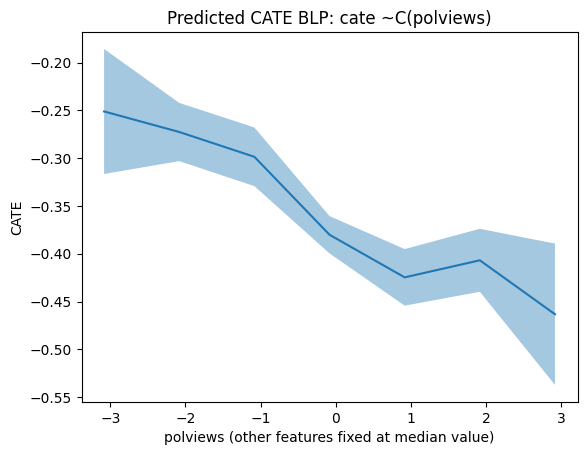

In [39]:
grid = np.unique(np.percentile(X[xfeat], np.arange(0, 102, 2)))
Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                   columns=X.columns)
Xpd[xfeat] = grid
pred_df = lr.get_prediction(Xpd).summary_frame(alpha=.1)
plt.plot(Xpd[xfeat], pred_df['mean'])
plt.fill_between(Xpd[xfeat], pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], alpha=.4)
plt.xlabel(xfeat + ' (other features fixed at median value)')
plt.title('Predicted CATE BLP: cate ~' + blp_formula)
plt.ylabel('CATE')
plt.show()

In [40]:
# now we repeat with polynomials of polviews up to degree 3

blp_formula_3 = "I(polviews**3) + I(polviews**2) + polviews + 1"
df = X.copy()
df['dr'] = dr_preds
lr = ols('dr ~ ' + blp_formula_3, df).fit(cov_type='HC1')
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     dr   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     20.38
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           3.61e-13
Time:                        08:30:35   Log-Likelihood:                -15686.
No. Observations:               12907   AIC:                         3.138e+04
Df Residuals:                   12903   BIC:                         3.141e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3761      0.009    -40.766      0.000      -0.394      -0.358
I(polviews ** 3)     0.0021      0.002      1.106      0.269      -0.002       0.006
I(polviews ** 2)     0.0056      0.003      1.806      0.071      -0.000       0.012
polviews            -0.0478      0.011     -4.510      0.000      -0.069      -0.027
==============================================================================
Omnibus:                     1115.076   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              642.459
Skew:                           0.407   Prob(JB):                    3.10e-140
Kurtosis:                       2.270   Cond. No.                         11.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

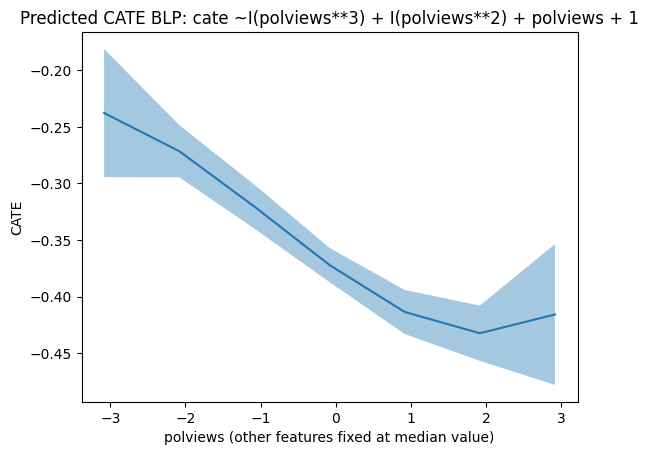

In [41]:
grid = np.unique(np.percentile(X[xfeat], np.arange(0, 102, 2)))
Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                   columns=X.columns)
Xpd[xfeat] = grid
pred_df = lr.get_prediction(Xpd).summary_frame(alpha=.1)
plt.plot(Xpd[xfeat], pred_df['mean'])
plt.fill_between(Xpd[xfeat], pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], alpha=.4)
plt.xlabel(xfeat + ' (other features fixed at median value)')
plt.title('Predicted CATE BLP: cate ~' + blp_formula_3)
plt.ylabel('CATE')
plt.show()

The coefficients for the second and third polynomials are 0.0056 and 0.0021 respectively

polviews


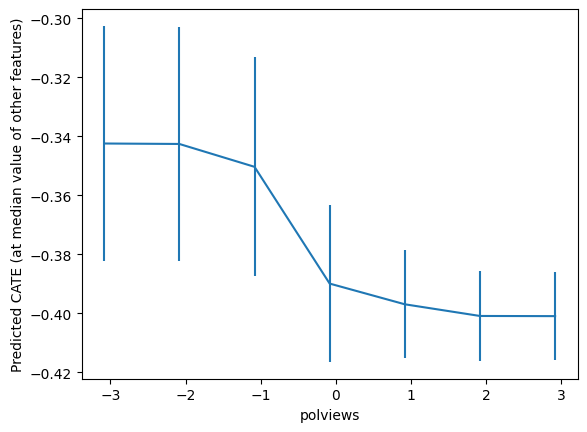

Index(['polviews', 'indus80', 'educ', 'hrs1'], dtype='object')


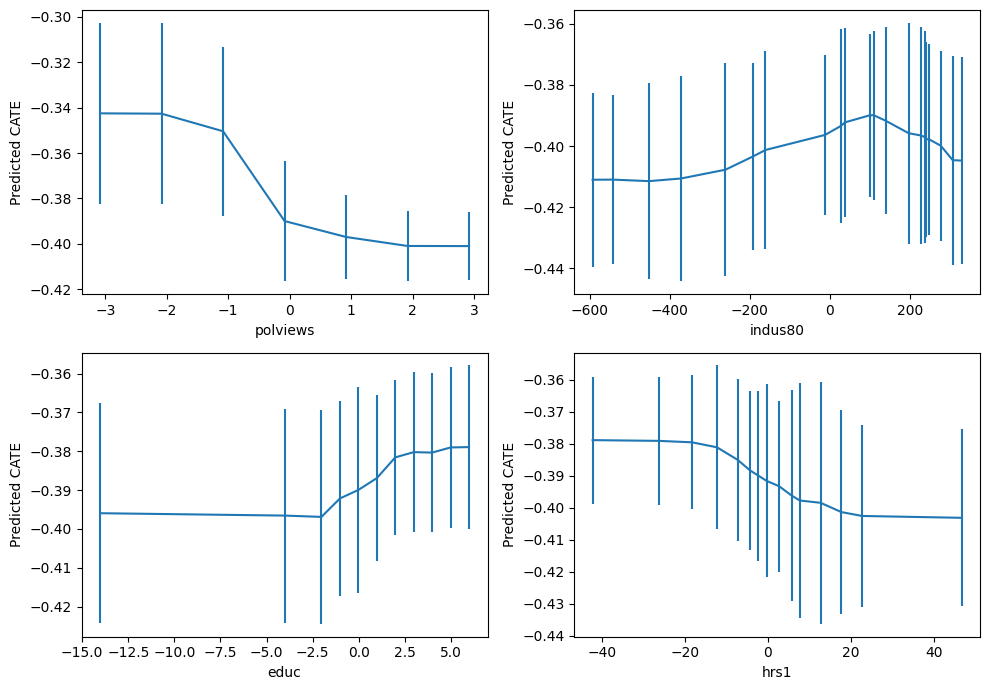

polviews


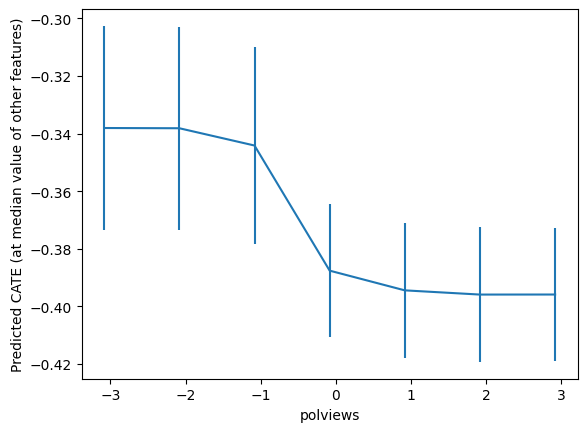

Index(['polviews', 'indus80', 'educ', 'hrs1'], dtype='object')


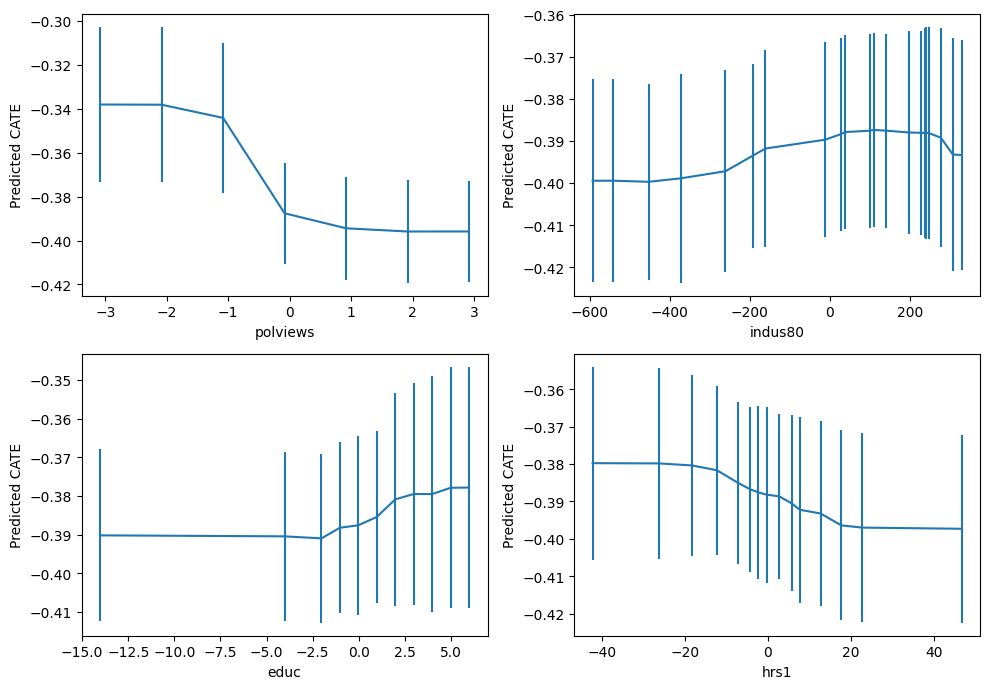

In [ ]:
# g.)

if hetero_feats == 'all':
    Z = X
else:
    Z = X[hetero_feats]
    
if Z.shape[0] > 1e6:
    min_samples_leaf = 500
    max_samples = 0.05
else:
    min_samples_leaf = 50
    max_samples = .4
    
from econml.grf import CausalForest

yres = y - res_preds
Dres = D - prop_preds
cf = CausalForest(4000, criterion='het', max_depth=None,
                  max_samples=max_samples,
                  min_samples_leaf=min_samples_leaf,
                  min_weight_fraction_leaf=.0,
                  random_state=random_seed)
cf.fit(Z, Dres, yres)

top_feat = np.argsort(cf.feature_importances_)[-1]
print(Z.columns[top_feat])

grid = np.unique(np.percentile(Z.iloc[:, top_feat], np.arange(0, 105, 5)))
Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                   columns=Z.columns)
Zpd.iloc[:, top_feat] = grid

preds, lb, ub = cf.predict(Zpd, interval=True, alpha=.1)
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd.iloc[:, top_feat], preds, yerr=(preds - lb, ub - preds))
plt.xlabel(Zpd.columns[top_feat])
plt.ylabel('Predicted CATE (at median value of other features)')
plt.savefig(f'{data}-causal-forest.png', dpi=600)
plt.show()

if semi_synth:
    true_proj = true_cate(X)
    preds, lb, ub = cf.predict(Z, interval=True, alpha=.1)
    preds = preds.flatten()
    lb = lb.flatten()
    ub = ub.flatten()
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], preds[inds])
    plt.fill_between(true_proj[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.xlabel('True CATE')
    plt.ylabel('Predicted CATE')
    plt.show()
    
    
important_feats = Z.columns[np.argsort(cf.feature_importances_)[::-1]]
print(important_feats[:4])

plt.figure(figsize=(10, 7))
for it, feature in enumerate(important_feats[:4]):
    plt.subplot(2, 2, it + 1)
    grid = np.unique(np.percentile(Z[feature], np.arange(0, 105, 5)))
    Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                       columns=Z.columns)
    Zpd[feature] = grid

    preds, lb, ub = cf.predict(Zpd, interval=True, alpha=.1)
    preds = preds.flatten()
    lb = lb.flatten()
    ub = ub.flatten()
    plt.errorbar(Zpd[feature], preds, yerr=(preds - lb, ub - preds))
    plt.xlabel(feature)
    plt.ylabel('Predicted CATE')
plt.tight_layout()
plt.savefig(f'{data}-cf-marginal-plots.png', dpi=600)
plt.show()

# doubly robust forests

from econml.grf import RegressionForest

drrf = RegressionForest(4000, max_depth=5,
                        max_samples=max_samples,
                        min_samples_leaf=min_samples_leaf,
                        min_weight_fraction_leaf=.0,
                        random_state=random_seed)
drrf.fit(Z, dr_preds)

top_feat = np.argsort(drrf.feature_importances_)[-1]
print(Z.columns[top_feat])


grid = np.unique(np.percentile(Z.iloc[:, top_feat], np.arange(0, 105, 5)))
Zpd = pd.DataFrame(np.tile(np.median(Z.values, axis=0, keepdims=True), (len(grid), 1)),
                   columns=Z.columns)
Zpd.iloc[:, top_feat] = grid

preds, lb, ub = drrf.predict(Zpd, interval=True, alpha=.1)
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd.iloc[:, top_feat], preds, yerr=(preds - lb, ub - preds))
plt.xlabel(Zpd.columns[top_feat])
plt.ylabel('Predicted CATE (at median value of other features)')
plt.savefig(f'{data}-doubly-robust-forest.png', dpi=600)
plt.show()

important_feats = Z.columns[np.argsort(drrf.feature_importances_)[::-1]]
print(important_feats[:4])

plt.figure(figsize=(10, 7))
for it, feature in enumerate(important_feats[:4]):
    plt.subplot(2, 2, it + 1)
    grid = np.unique(np.percentile(Z[feature], np.arange(0, 105, 5)))
    Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                       columns=Z.columns)
    Zpd[feature] = grid

    preds, lb, ub = drrf.predict(Zpd, interval=True, alpha=.1)
    preds = preds.flatten()
    lb = lb.flatten()
    ub = ub.flatten()
    plt.errorbar(Zpd[feature], preds, yerr=(preds - lb, ub - preds))
    plt.xlabel(feature)
    plt.ylabel('Predicted CATE')
plt.tight_layout()
plt.savefig(f'{data}-drrf-marginal-plots.png', dpi=600)
plt.show()

if semi_synth:
    true_proj = true_cate(X)
    preds, lb, ub = drrf.predict(Z, interval=True, alpha=.1)
    preds = preds.flatten()
    lb = lb.flatten()
    ub = ub.flatten()
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], preds[inds])
    plt.fill_between(true_proj[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.xlabel('True CATE')
    plt.ylabel('Predicted CATE')
    plt.show()

The most important feature in the causal forest as measure by feature importance is polviews. There is hardly any difference between the causal forest and the doubly robust forest. The same four features are the most important in both forests. The most noticeable difference is that the cate plot for indus80 looks a little flatter for the doubly robust forest, but overall all the results are very similar.

### Assignment 2

In [43]:
! pip install xgboost==2.0.1
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import wget
import os

verbose = 0  # verbosity of auto-ml
n_splits = 5  # cross-fitting and cross-validation splits
cfit = True
data = 'welfare'  # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'star'}
plot = True  # whether to plot results
# feature to use as x axis in plotting, e.g. for criteo 'f1', for 401k 'inc', for welfare 'polviews'
xfeat = 'polviews'
# Formula for the BLP of CATE regression.
blp_formula = 'C(polviews)'  # e.g. 'f1' for criteo, np.log(inc)' for 401k, 'C(polviews)' for the welfare case.
blp_formula_short = 'C(polviews)'
blp_formula2 = 'polviews'
blp_formula2_short = 'polviews'
control_feats = 'all'  # list of subset of features to be used as confounders or the string 'all' for everything
# list of subset of control features to be used for CATE model or the string 'all' for all controls
hetero_feats = 'all'
cov_clip = .01  # clipping of treatment variance p(x)*(1-p(x)), whenever used in inverse propensities
binary_y = True
random_seed = 1

# cost of treatment when performing optimal policy learning, can also be viewed as "threshold for treatment"
treatment_cost = -.3

# For semi-synthetic data generation
semi_synth = False  # Whether true outcome y should be replaced by a fake outcome from a known CEF
simple_synth = True  # Whether the true CEF of the fake y should be simple or fitted from data
max_depth = 2  # max depth of random forest during for semi-synthetic model fitting
scale = .2  # magnitude of noise in semi-synthetic data

def simple_true_cef(D, X):  # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

from datasets import fetch_data_generator

get_data, abtest, true_cef, true_cate = fetch_data_generator(data=data, semi_synth=semi_synth,
                                                             simple_synth=simple_synth,
                                                             scale=scale, true_f=simple_true_cef,
                                                             max_depth=max_depth)
X, D, y, groups = get_data()

if semi_synth:
    true_ate = np.mean(true_cate(X))
    print(f'True ATE: {true_ate}')
    
def rmse(cate, preds):
    return np.sqrt(np.mean((cate - preds)**2))

if control_feats != 'all':
    X = X[control_feats]
    print(X.describe())
    
X = X - X.mean(axis=0)

# simple two means estimate which would be wrong unless an randomized trial
OLS(y, np.hstack([np.ones((D.shape[0], 1)), D.reshape(-1, 1)])).fit(cov_type='HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     2476.
Date:                Wed, 05 Mar 2025   Prob (F-statistic):               0.00
Time:                        08:31:00   Log-Likelihood:                -6969.7
No. Observations:               12907   AIC:                         1.394e+04
Df Residuals:                   12905   BIC:                         1.396e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4798      0.006     76.111      0.000       0.467       0.492
x1            -0.3681      0.007    -49.761      0.000      -0.383      -0.354
==============================================================================
Omnibus:                     1655.598   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1148.663
Skew:                           0.621   Prob(JB):                    3.72e-250
Kurtosis:                       2.230   Cond. No.                         2.65
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Split Train and Validation and Test  

The training data will be used to fit the various CATE models. The validation data will be used for scoring and selection of the best CATE model or best ensemble of CATE models. The test data will be used for testing and evaluation of the performance of the best chosen model.

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit

DX = np.column_stack((D, X))
labels = np.column_stack((D, y)) if binary_y else D
train, val = next(StratifiedShuffleSplit(n_splits=2, train_size=.6,
                                         random_state=random_seed).split(DX, labels))
X, Xval, D, Dval, y, yval = X.iloc[train], X.iloc[val], D[train], D[val], y[train], y[val]

DXval = np.column_stack((Dval, Xval))
labels_val = np.column_stack((Dval, yval)) if binary_y else Dval
val, test = next(StratifiedShuffleSplit(n_splits=2, train_size=.6,
                                        random_state=random_seed).split(DXval, labels_val))
Xval, Xtest, Dval, Dtest, yval, ytest = Xval.iloc[val], Xval.iloc[test], Dval[val], Dval[test], yval[val], yval[test]

# Nuisance Cross-Fitted Estimation and Prediction

We will estimate regression models for each of the nuisance functions that arise in CATE learning approaches. The five models correspond to the following five predictive problems:
\begin{align}
\text{model y} ~\rightarrow q(x) := E[Y\mid X=x]\\
\text{model t} ~\rightarrow p(x) := E[D\mid X=x] = \Pr(D=1\mid X=x)\\
\text{model reg zero} ~\rightarrow g_0(x) := E[Y\mid D=0, X=x]\\
\text{model reg one} ~\rightarrow g_1(x) := E[Y\mid D=1, X=x]\\
\end{align}
We will use gradient boosting regression with early stopping for each of these models.

For each of the nuisance models we perform cross-fitting to get out-of-fold predictions from each of these nuisance models. At the end of this process, we will have for each sample $i$, the following out-of-fold nuisance values:
\begin{align}
\text{reg preds t} \rightarrow \hat{g}_0(X_i) (1 - D_i) + \hat{g}_1(X_i) D_i \\
\text{reg one preds t} \rightarrow \hat{g}_1(X_i) \\
\text{reg zero preds t} \rightarrow \hat{g}_0(X_i)\\
\text{res preds} \rightarrow~& \hat{q}(X_i) \\
\text{prop preds} \rightarrow~& \hat{p}(X_i)\\
\end{align}

In [45]:
from myxgb import xgb_reg, xgb_clf, xgb_wreg, RegWrapper


def auto_reg():
    return xgb_reg(random_seed)


# Disclaimer: The remainder of the code assumes that the `auto_clf` model returns
# the probability of class 1, when one calls auto_clf().predict(X)
# and not the 0/1 classification. This is what the xgb_clf class does.
def auto_clf():
    return RegWrapper(xgb_clf(random_seed))


def auto_weighted_reg():
    return xgb_wreg(random_seed)


modely = auto_clf if binary_y else auto_reg

if cfit:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    stratification_label = 2 * D + y if binary_y else D
    splits = list(cv.split(X, stratification_label))
else:
    splits = [(np.arange(X.shape[0]), np.arange(X.shape[0]))]

n = X.shape[0]
reg_preds = np.zeros(n)
reg_zero_preds = np.zeros(n)
reg_one_preds = np.zeros(n)
reg_preds_t = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

DX = np.column_stack((D, X))
for train, test in splits:
    reg = modely().fit(DX[train], y[train])
    reg_preds[test] = reg.predict(DX[test])
    reg_one_preds[test] = reg.predict(np.column_stack([np.ones(len(test)), X.iloc[test]]))
    reg_zero_preds[test] = reg.predict(np.column_stack([np.zeros(len(test)), X.iloc[test]]))

    reg_zero = modely().fit(X.iloc[train][D[train] == 0], y[train][D[train] == 0])
    reg_one = modely().fit(X.iloc[train][D[train] == 1], y[train][D[train] == 1])
    reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test])
    reg_one_preds_t[test] = reg_one.predict(X.iloc[test])
    reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test]

res_preds = cross_val_predict(modely(), X, y, cv=splits)
prop_preds = cross_val_predict(auto_clf(), X, D, cv=splits)

# We now evaluate nuisance model performance of the selected models in terms of R^2
def r2score(y, ypred):
    return 1 - np.mean((y - ypred)**2) / np.var(y)

print(f"R^2 of model for (y ~ X): {r2score(y, res_preds):.4f}")
print(f"R^2 of model for (D ~ X): {r2score(D, prop_preds):.4f}")
print(f"R^2 of two-learner model for (y ~ X | D==0): {r2score(y[D == 0], reg_zero_preds_t[D == 0]):.4f}")
print(f"R^2 of two-learner model for (y ~ X | D==1): {r2score(y[D == 1], reg_one_preds_t[D == 1]):.4f}")
print(f"R^2 of two-learner model for (y ~ D, X): {r2score(y, reg_preds_t):.4f}")
print(f"R^2 of single-learner model for (y ~ D, X): {r2score(y, reg_preds):.4f}")



R^2 of model for (y ~ X): 0.0456
R^2 of model for (D ~ X): -0.0002
R^2 of two-learner model for (y ~ X | D==0): 0.0707
R^2 of two-learner model for (y ~ X | D==1): 0.0355
R^2 of two-learner model for (y ~ D, X): 0.2145
R^2 of single-learner model for (y ~ D, X): 0.2155


Using the doubly robust method. In particular, we construct the doubly robust variables
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) := \hat{g}_1(X_i) - \hat{g}_0(X_i) + (Y_i - \hat{g}_{D_i}(X_i))\frac{D_i - \hat{p}(X_i)}{\hat{p}(X_i) (1-\hat{p}(X_i))}
\end{align}
and then we estimate:
\begin{align}
ATE = E_n\left[Y^{DR}(\hat{g},\hat{p})\right]
\end{align}
This should be more efficient in the worst-case and should be returning a consistent estimate of the ATE even beyond RCTs and will also correctly account for any imbalances or violations of the randomization assumption in an RCT.

In [46]:
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), cov_clip, np.inf)

OLS(dr_preds, np.ones((len(dr_preds), 1))).fit(cov_type='HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 05 Mar 2025   Prob (F-statistic):                nan
Time:                        08:31:03   Log-Likelihood:                -9428.4
No. Observations:                7744   AIC:                         1.886e+04
Df Residuals:                    7743   BIC:                         1.887e+04
Df Model:                           0                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3656      0.009    -39.347      0.000      -0.384      -0.347
==============================================================================
Omnibus:                      907.837   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              416.585
Skew:                           0.393   Prob(JB):                     3.47e-91
Kurtosis:                       2.179   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [47]:
from statsmodels.formula.api import ols
df = X.copy()
df['dr'] = dr_preds
lr = ols('dr ~ ' + blp_formula, df).fit(cov_type='HC1')
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     dr   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.285
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           8.88e-08
Time:                        08:31:03   Log-Likelihood:                -9408.0
No. Observations:                7744   AIC:                         1.883e+04
Df Residuals:                    7737   BIC:                         1.888e+04
Df Model:                           6                                         
Covariance Type:                  HC1                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.2368      0.054     -4.377      0.000      -0.343      -0.131
C(polviews)[T.-2.083443092895328]      -0.0319      0.059     -0.537      0.591      -0.148       0.084
C(polviews)[T.-1.0834430928953278]     -0.0511      0.059     -0.865      0.387      -0.167       0.065
C(polviews)[T.-0.08344309289532781]    -0.1540      0.056     -2.739      0.006      -0.264      -0.044
C(polviews)[T.0.9165569071046722]      -0.1826      0.059     -3.102      0.002      -0.298      -0.067
C(polviews)[T.1.9165569071046722]      -0.1668      0.060     -2.788      0.005      -0.284      -0.050
C(polviews)[T.2.916556907104672]       -0.2045      0.083     -2.476      0.013      -0.366      -0.043
==============================================================================
Omnibus:                      692.834   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              396.700
Skew:                           0.414   Prob(JB):                     7.20e-87
Kurtosis:                       2.262   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

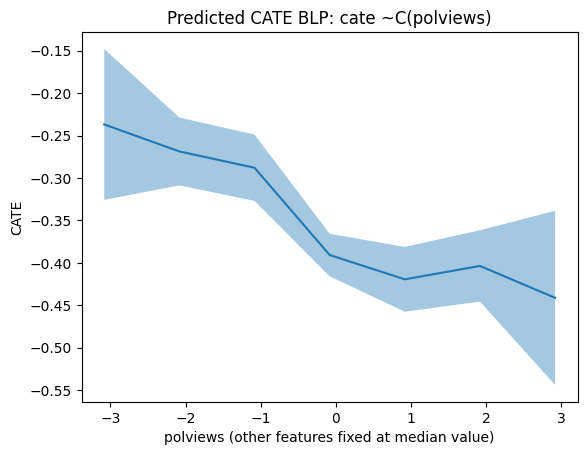

In [48]:
grid = np.unique(np.percentile(X[xfeat], np.arange(0, 102, 2)))
Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                   columns=X.columns)
Xpd[xfeat] = grid
pred_df = lr.get_prediction(Xpd).summary_frame(alpha=.1)
plt.plot(Xpd[xfeat], pred_df['mean'])
plt.fill_between(Xpd[xfeat], pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], alpha=.4)
plt.xlabel(xfeat + ' (other features fixed at median value)')
plt.title('Predicted CATE BLP: cate ~' + blp_formula)
plt.ylabel('CATE')
plt.show()

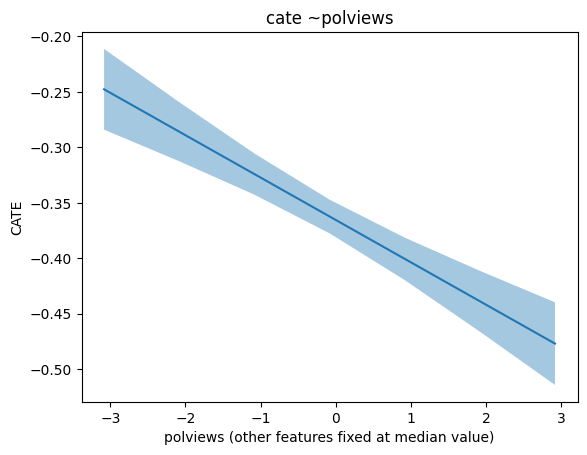

In [49]:
from statsmodels.formula.api import ols
df = X.copy()
df['dr'] = dr_preds
lr = ols('dr ~ ' + blp_formula2, df).fit(cov_type='HC1')
grid = np.unique(np.percentile(X[xfeat], np.arange(0, 102, 2)))
Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                   columns=X.columns)
Xpd[xfeat] = grid
pred_df2 = lr.get_prediction(Xpd).summary_frame(alpha=.1)
plt.plot(Xpd[xfeat], pred_df2['mean'])
plt.fill_between(Xpd[xfeat], pred_df2['mean_ci_lower'], pred_df2['mean_ci_upper'], alpha=.4)
plt.xlabel(xfeat + ' (other features fixed at median value)')
plt.ylabel('CATE')
plt.title('cate ~' + blp_formula2)
plt.show()

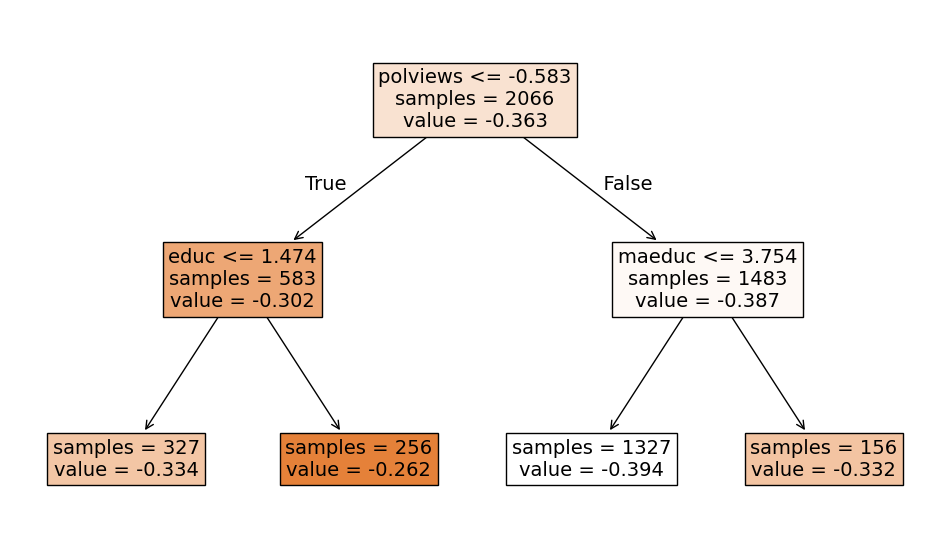

In [50]:
# CATE Model Estimation with Meta-Learners
# We specify which indeces of the X variables we want to use for heterogeneity. Let's denote these subset of variables with Z. 

if hetero_feats == 'all':
    hetero_feats = X.columns
Z, Zval, Ztest = X[hetero_feats], Xval[hetero_feats], Xtest[hetero_feats]

# slearner
slearner = auto_reg().fit(Z, reg_one_preds - reg_zero_preds)
slearner_cates = slearner.predict(Z)

# tlearner
tlearner = auto_reg().fit(Z, reg_one_preds_t - reg_zero_preds_t)
tlearner_cates = tlearner.predict(Z)

# xlearner
tau1_preds = y[D == 1] - reg_zero_preds_t[D == 1]
tau0_preds = reg_one_preds_t[D == 0] - y[D == 0]
tau1 = auto_reg().fit(X[D == 1], tau1_preds)
tau0 = auto_reg().fit(X[D == 0], tau0_preds)
xtarget = prop_preds * tau0.predict(X) + (1 - prop_preds) * tau1.predict(X)
xlearner = auto_reg().fit(Z, xtarget)
xlearner_cates = xlearner.predict(Z)

# drlearner
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), cov_clip, np.inf)
drlearner = auto_reg().fit(Z, dr_preds)
drlearner_cates = drlearner.predict(Z)

# rlearner
yres = y - res_preds
Dres = D - prop_preds
Dres = np.clip(Dres, 1e-6, np.inf) * (Dres >= 0) + np.clip(Dres, -np.inf, -1e-6) * (Dres < 0)

rlearner = auto_weighted_reg().fit(Z.values, yres / Dres, sample_weight=Dres**2)

rlearner_cates = rlearner.predict(Z)

# Constant Effect DR learner (We also add a heavily regularized CATE model that predicts the ATE using the doubly robust pseudo outcomes)

drlearner_const = make_pipeline(PolynomialFeatures(degree=0, include_bias=True),
                                LinearRegression(fit_intercept=False))
drlearner_const.fit(Z, dr_preds)
drlearner_const_cates = drlearner_const.predict(Z)

# Interpretability 

plt.figure(figsize=(12, 7))
tree = DecisionTreeRegressor(max_depth=2, min_samples_leaf=100,
                             min_impurity_decrease=.0001, random_state=random_seed)
tree.fit(Ztest, drlearner.predict(Ztest))
plot_tree(tree, filled=True, feature_names=list(Ztest.columns), fontsize=14, impurity=False)
plt.savefig(f'{data}-distill-tree-cate-dr.png', dpi=600)
plt.show()

Causal Score Estimation and Definition  
  
We want to be able to select among all these different meta learners. For this reason we will use scoring functions that can evaluate the performance of an arbitrary CATE function and is not tailored to any particular methodology. This way we can evaluate all methods using the same score on the validation set and select the best among the methods, or ensemble the methods using this scoring metric. We will describe one such meta scores, the `DR-score`.  
  
The doubly robust score:  
  
The doubly robust score calculates the doubly robust proxy variables $Y_i^{DR}(g,p)$, where $g,p$ are fitted on the training set (or on the validatino in a cross-fitting manner). Then for any candidate CATE model $\hat{\tau}$, the DR-score is the decrease in residual variance of $Y^{DR}(g,p)$ based on the candidate model as compared to a constant effect model.
\begin{align}
\text{DRscore}(\hat{\tau}) := E_n\left[\left(Y^{DR}(g,p) - \tau_{\text{constant}}(Z)\right)^2\right] - E_n\left[\left(Y^{DR}(g,p) - \hat{\tau}(Z)\right)^2\right]
\end{align}
We can also consider normalizing by the residual variance of the constant effect model
\begin{align}
\text{DRscore}(\hat{\tau}) := \frac{E_n\left[\left(Y^{DR}(g,p) - \tau_{\text{constant}}(Z)\right)^2\right] - E_n\left[\left(Y^{DR}(g,p) - \hat{\tau}(Z)\right)^2\right]}{E_n\left[\left(Y^{DR}(g,p) - \tau_{\text{constant}}(Z)\right)^2\right]}
\end{align}
for more interpretability, as this last quanity lies in $[-\infty, 1]$, and for any decent model it should be a positive number in $[0,1]$.

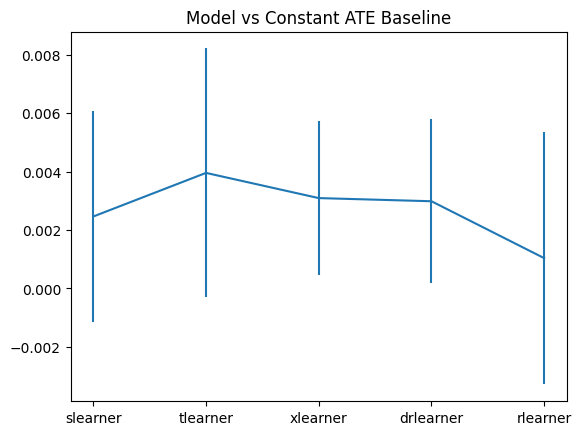

['slearner: 0.0025', 'tlearner: 0.0040', 'xlearner: 0.0031', 'drlearner: 0.0030', 'rlearner: 0.0010', 'drlearner_const: -0.0000']
slearner: 0.0025 (0.0018) [-0.0011, 0.0061]
tlearner: 0.0040 (0.0022) [-0.0003, 0.0082]
xlearner: 0.0031 (0.0014) [0.0004, 0.0057]
drlearner: 0.0030 (0.0014) [0.0002, 0.0058]
rlearner: 0.0010 (0.0022) [-0.0033, 0.0054]
drlearner_const: -0.0000 (0.0000) [-0.0000, -0.0000]


In [51]:
reg_zero_on_train = modely().fit(X[D == 0], y[D == 0])
reg_one_on_train = modely().fit(X[D == 1], y[D == 1])
prop_on_train = auto_clf().fit(X, D)


def calculate_dr_outcomes(reg_zero, reg_one, prop, Xval, Dval, yval):

    reg_zero_preds_t = reg_zero.predict(Xval)
    reg_one_preds_t = reg_one.predict(Xval)
    reg_preds_t = reg_zero_preds_t * (1 - Dval) + reg_one_preds_t * Dval
    prop_preds = prop.predict(Xval)

    dr = reg_one_preds_t - reg_zero_preds_t
    reisz = (Dval - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .01, np.inf)
    dr += (yval - reg_preds_t) * reisz

    return dr

dr_val = calculate_dr_outcomes(reg_zero_on_train, reg_one_on_train, prop_on_train,
                               Xval, Dval, yval)

overall_ate_val_dr = np.mean(dr_preds)


def drscore(cate_preds):
    drscore_t = np.mean((dr_val - cate_preds)**2)
    drscore_b = np.mean((dr_val - overall_ate_val_dr)**2)
    return drscore_b - drscore_t


def drscore_delta(cate_preds1, cate_preds2=overall_ate_val_dr):
    drscore_t = np.mean((dr_val - cate_preds1)**2)
    drscore_b = np.mean((dr_val - cate_preds2)**2)
    stderr = np.std((dr_val - cate_preds2)**2 - (dr_val - cate_preds1)**2) / np.sqrt(cate_preds1.shape[0])
    return drscore_b - drscore_t, stderr

# Compare models with confidence

names = ['slearner', 'tlearner', 'xlearner', 'drlearner', 'rlearner']
models = [slearner, tlearner, xlearner, drlearner, rlearner]

points, ses = zip(*[drscore_delta(model.predict(Zval)) for model in models])
points = np.array(points)
ses = np.array(ses)

plt.errorbar(names, points, yerr=[1.96 * ses, 1.96 * ses])
plt.title('Model vs Constant ATE Baseline')
plt.savefig(f'{data}-model-comparison.png', dpi=600)
plt.show()

# Score cate models

scorer = drscore
score_name = 'DRscore'
names = ['slearner', 'tlearner', 'xlearner', 'drlearner', 'rlearner', 'drlearner_const']
models = [slearner, tlearner, xlearner, drlearner, rlearner, drlearner_const]

scores = [scorer(model.predict(Zval)) for model in models]
print([f'{name}: {score:.4f}' for name, score in zip(names, scores)])

for name, model in zip(names, models):
    score = drscore_delta(model.predict(Zval))
    print(f'{name}: {score[0]:.4f} ({score[1]:.4f}) '
          f'[{score[0] - 1.96 * score[1]:.4f}, {score[0] + 1.96 * score[1]:.4f}]')

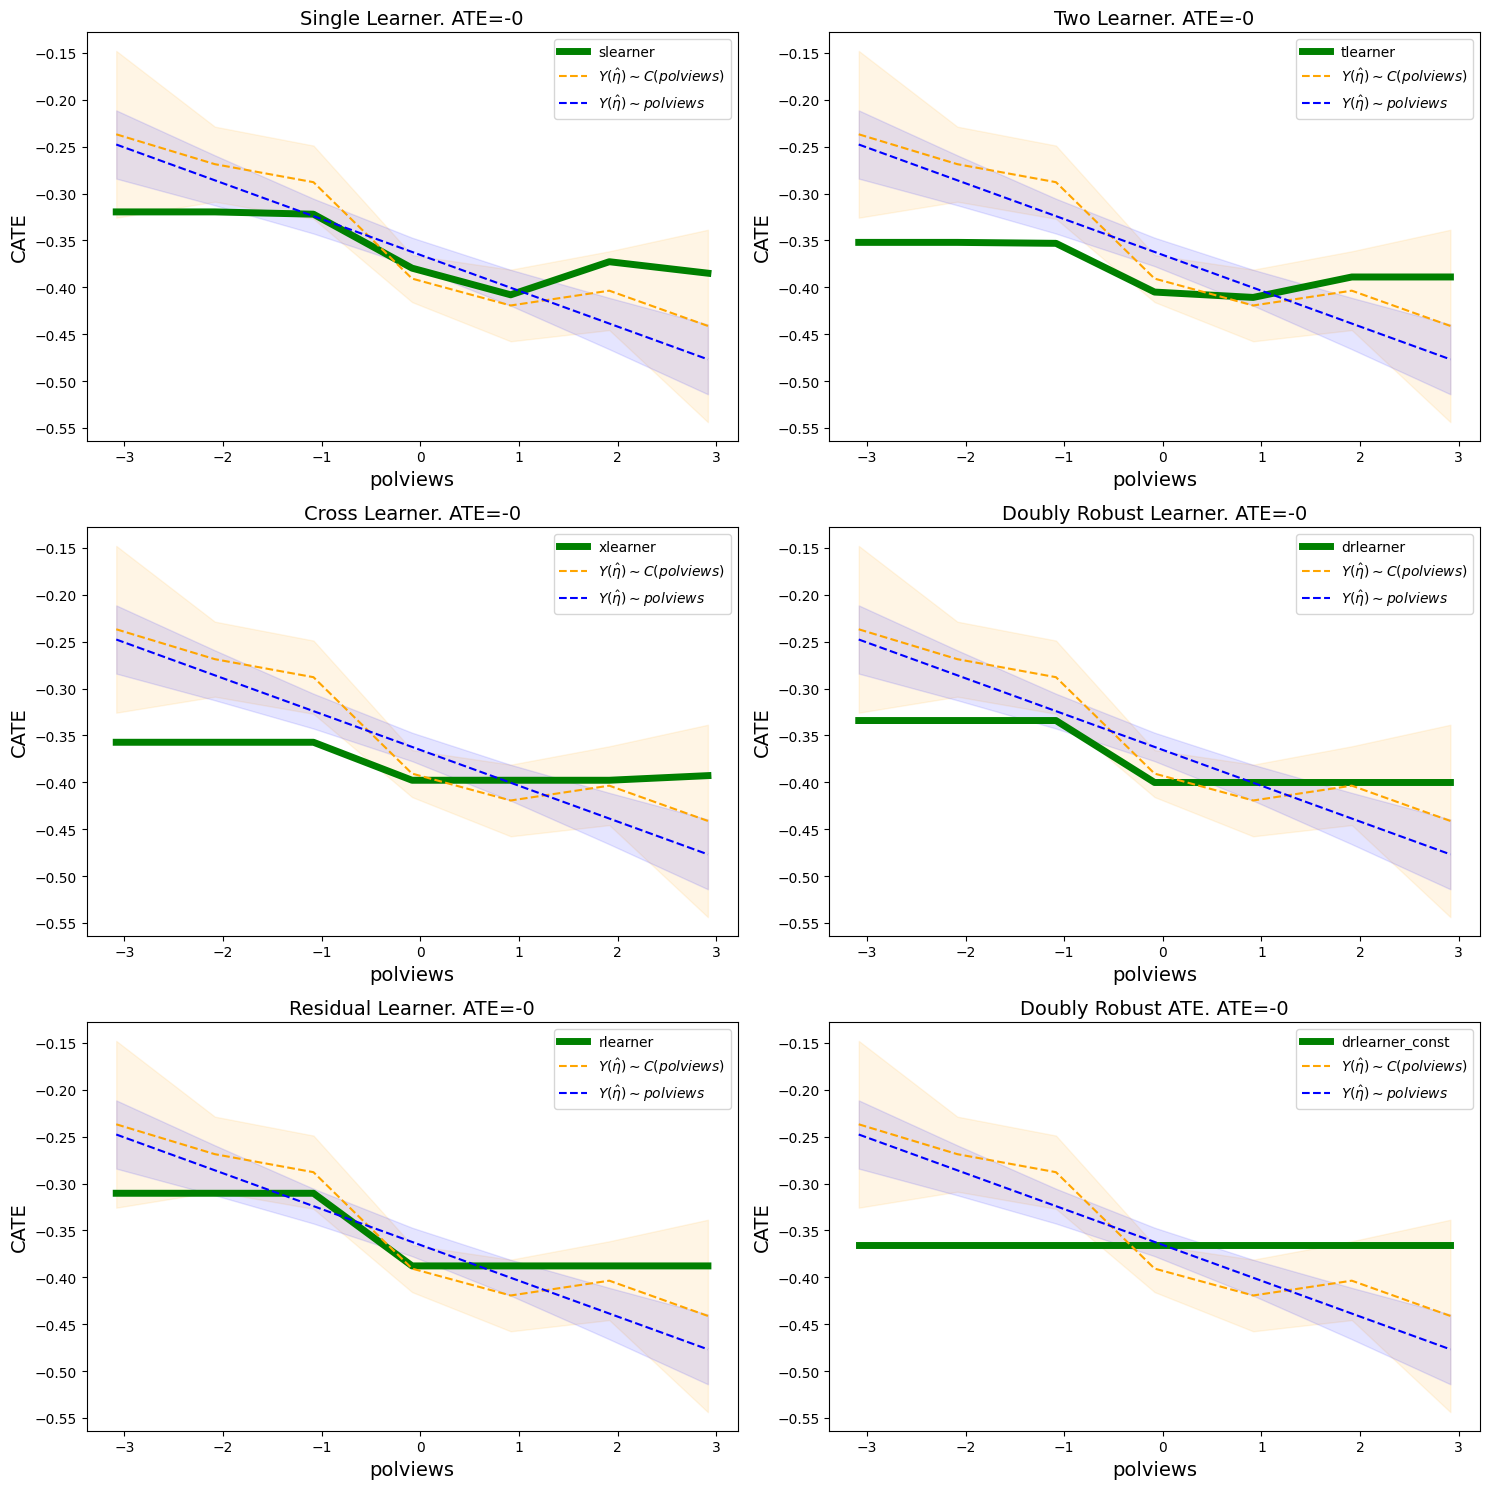

In [52]:
# Plotting CATE 

fnames = ['Single Learner', 'Two Learner', 'Cross Learner',
          'Doubly Robust Learner', 'Residual Learner', 'Doubly Robust ATE']

if plot:
    grid = np.unique(np.percentile(X[xfeat], np.arange(0, 102, 2)))
    Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                       columns=X.columns)
    Xpd[xfeat] = grid
    plt.figure(figsize=(15, 15))
    for it, (fname, name, model, score) in enumerate(zip(fnames, names, models, scores)):
        plt.subplot(3, len(models) // 3, it + 1)
        preds = model.predict(Xpd[hetero_feats])
        plt.plot(Xpd[xfeat], preds, linewidth=5, color='green', label=name)
        plt.plot(Xpd[xfeat], pred_df['mean'], '--',
                 color='orange', label='$Y(\\hat{\\eta})\\sim ' + f'{blp_formula_short}$')
        plt.fill_between(Xpd[xfeat], pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], color='orange', alpha=.1)
        plt.plot(Xpd[xfeat], pred_df2['mean'], '--',
                 color='blue', label='$Y(\\hat{\\eta})\\sim ' + f'{blp_formula2_short}$')
        plt.fill_between(Xpd[xfeat], pred_df2['mean_ci_lower'], pred_df2['mean_ci_upper'], color='blue', alpha=.1)
        if semi_synth:
            plt.plot(Xpd[xfeat], true_cate(Xpd), label='True')
            plt.title(f'{score_name}={score:.4f}, True RMSE={rmse(true_cate(X), model.predict(Z)):.5f}')
        else:
            plt.title(f'{fname}. ATE={np.mean(model.predict(Zval)):.0f}', fontsize=14)
        plt.legend()
        plt.xlabel(xfeat, fontsize=14)
        plt.ylabel('CATE', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{data}-metalearners.png', dpi=600)
    plt.show()

a.)  
  
The meta learners fitted on the dataset are:  
1. S-learner
2. T-learner
3. X-learner
4. DR-learner
5. R-learner

The score used to select among the different meta learners is the DR-score, which is described above. The meta-learners with a score that is statistically better than the score achieved by the constant treatment effect predictor are X-learner and the DR-learner.   

Qualitatively, the X-learner and the DR-learner uncover treatment effect heterogeneity with respect to polvies in their causal effect estimates that the constant learner does not. Specifically, the constant leraner estimates a constant ATE of around -0.36, while both the X-learner and the DR-learner estimate a treatment effect that is slightly less negative for individuals with polvies from -3 to -1 (around - 0.355 for X-learner, -0.33 for DR-learner) and slightly more negative for polviews from 0 to 3 (just over -0.4 for X-learner, around -0.4 for DR learner).

Causal Model Selection and Ensembling

We can also use these scores to create an ensemble CATE model of the different methods based on the score performance. We want to create a new CATE model $\tau_E$ that is a weighted linear combination of all the cate models, i.e.
\begin{align}
\tau_E(Z) = \bar{\tau} + \sum_{m=1}^M w_m \tau_m(Z)
\end{align}
One way to achieve that is to choose the model with the best score. However, the discontinuity in this selection process can be statistically suboptimal. One way to achieve this in a smoother manner is to perform Stacking to construct the ensemble weights.

We perform Stacking by fitting a (potentially $\ell_1$-penalized) linear model to minimize the corresponding loss. For the case of the DR score this boils down to a penalized linear regression, predicting $Y^{DR}(g,p)$ on the validation set, using $\tau_1(Z),\ldots, \tau_M(Z)$ as technical regressors:
\begin{align}
\min_{w} E_n\left[ \left(Y^{DR}(g,p) - \bar{\tau} - \sum_{m=1}^M w_m \tilde{\tau}_m(Z)\right)^2 \right] + \lambda \text{Penalty}(w)
\end{align}
where $\bar{\tau}$ is the ATE estimate based on the doubly robust method on the training data and $\tilde{\tau}_m(Z)$ are the de-meaned CATE predictions from each model, i.e. $\tilde{\tau}_m(Z) = \tau_m(Z) - E_n[\tau_m(Z)]$ where the empirical expectation is over the training data.

This way we are constructing an ensemble of the CATE on top of the best constant prediction on the training data and penalizing only the offset from this ATE. We avoid adding a coefficient around $\bar{\tau}$ to avoid introducing noise to the ATE estimate, due to the smaller sample in the validation set.

Q-aggregation optimizes a penalized objective of the form:
\begin{align}
\min_{w\in \Delta(M)} (1 - \nu) E_n\left[ \left(Y^{DR}(g,p) - \bar{\tau} - \sum_{m=1}^M w_m \tilde{\tau}_m(Z)\right)^2 \right] + \nu \sum_{m=1}^M w_m E_n\left[ \left(Y^{DR}(g,p) - \bar{\tau} - \tilde{\tau}_m(Z)\right)^2 \right]
\end{align}
where $\Delta(M)$ is the simplex in $M$ dimensions, i.e.
\begin{align}
\Delta(M) := \{w\in R^M: w_i\geq 0, \sum_{m=1}^M w_m=1\}.
\end{align}

In other words, it chooses a convex combination of models, but penalizes models which do not perform well individually. Note that when $\nu=0$, then this boils down to what is known as "convex regression", i.e. OLS regression subject to a simplex constraint on the coefficients. When $\nu=1$, then the above boils down to choosing the single best performing model. Hence, Q-aggregation interpolates between the best convex combination of models and the single best performing model. It enjoys favorable theoretical guarantees as compared to either of the two extremes.

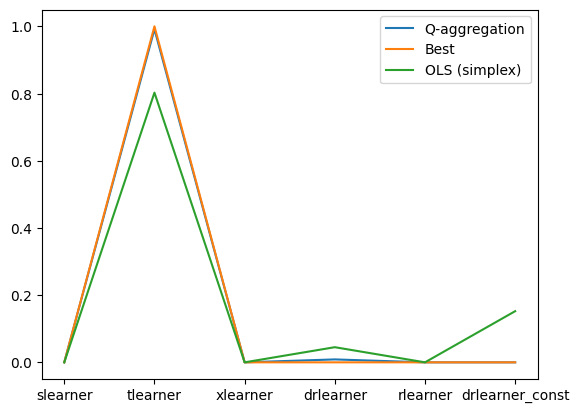

Weights for Q-aggregation: [8.37080221e-17 9.91303180e-01 0.00000000e+00 8.69682050e-03
 4.15536372e-17 6.22563919e-17]
Weights for Best: [2.36894422e-19 1.00000000e+00 0.00000000e+00 0.00000000e+00
 1.53928282e-19 3.04596225e-19]
Weights for OLS (simplex): [1.53362299e-17 8.02662359e-01 2.04358238e-16 4.50531661e-02
 6.15799941e-26 1.52284474e-01]


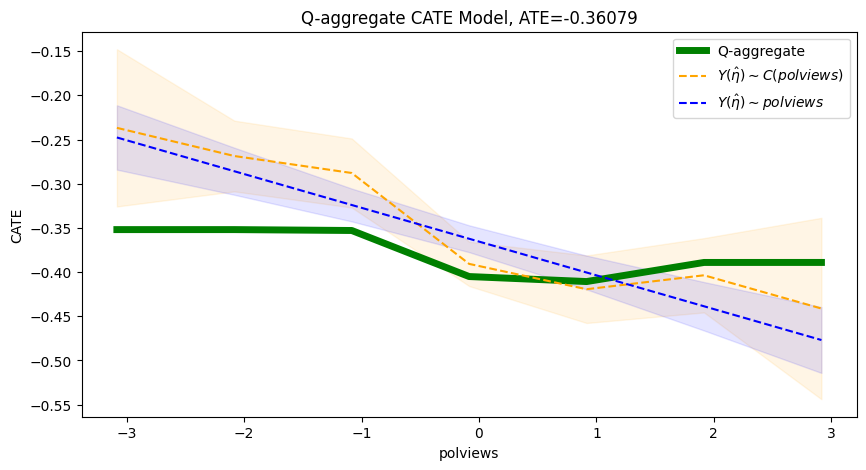

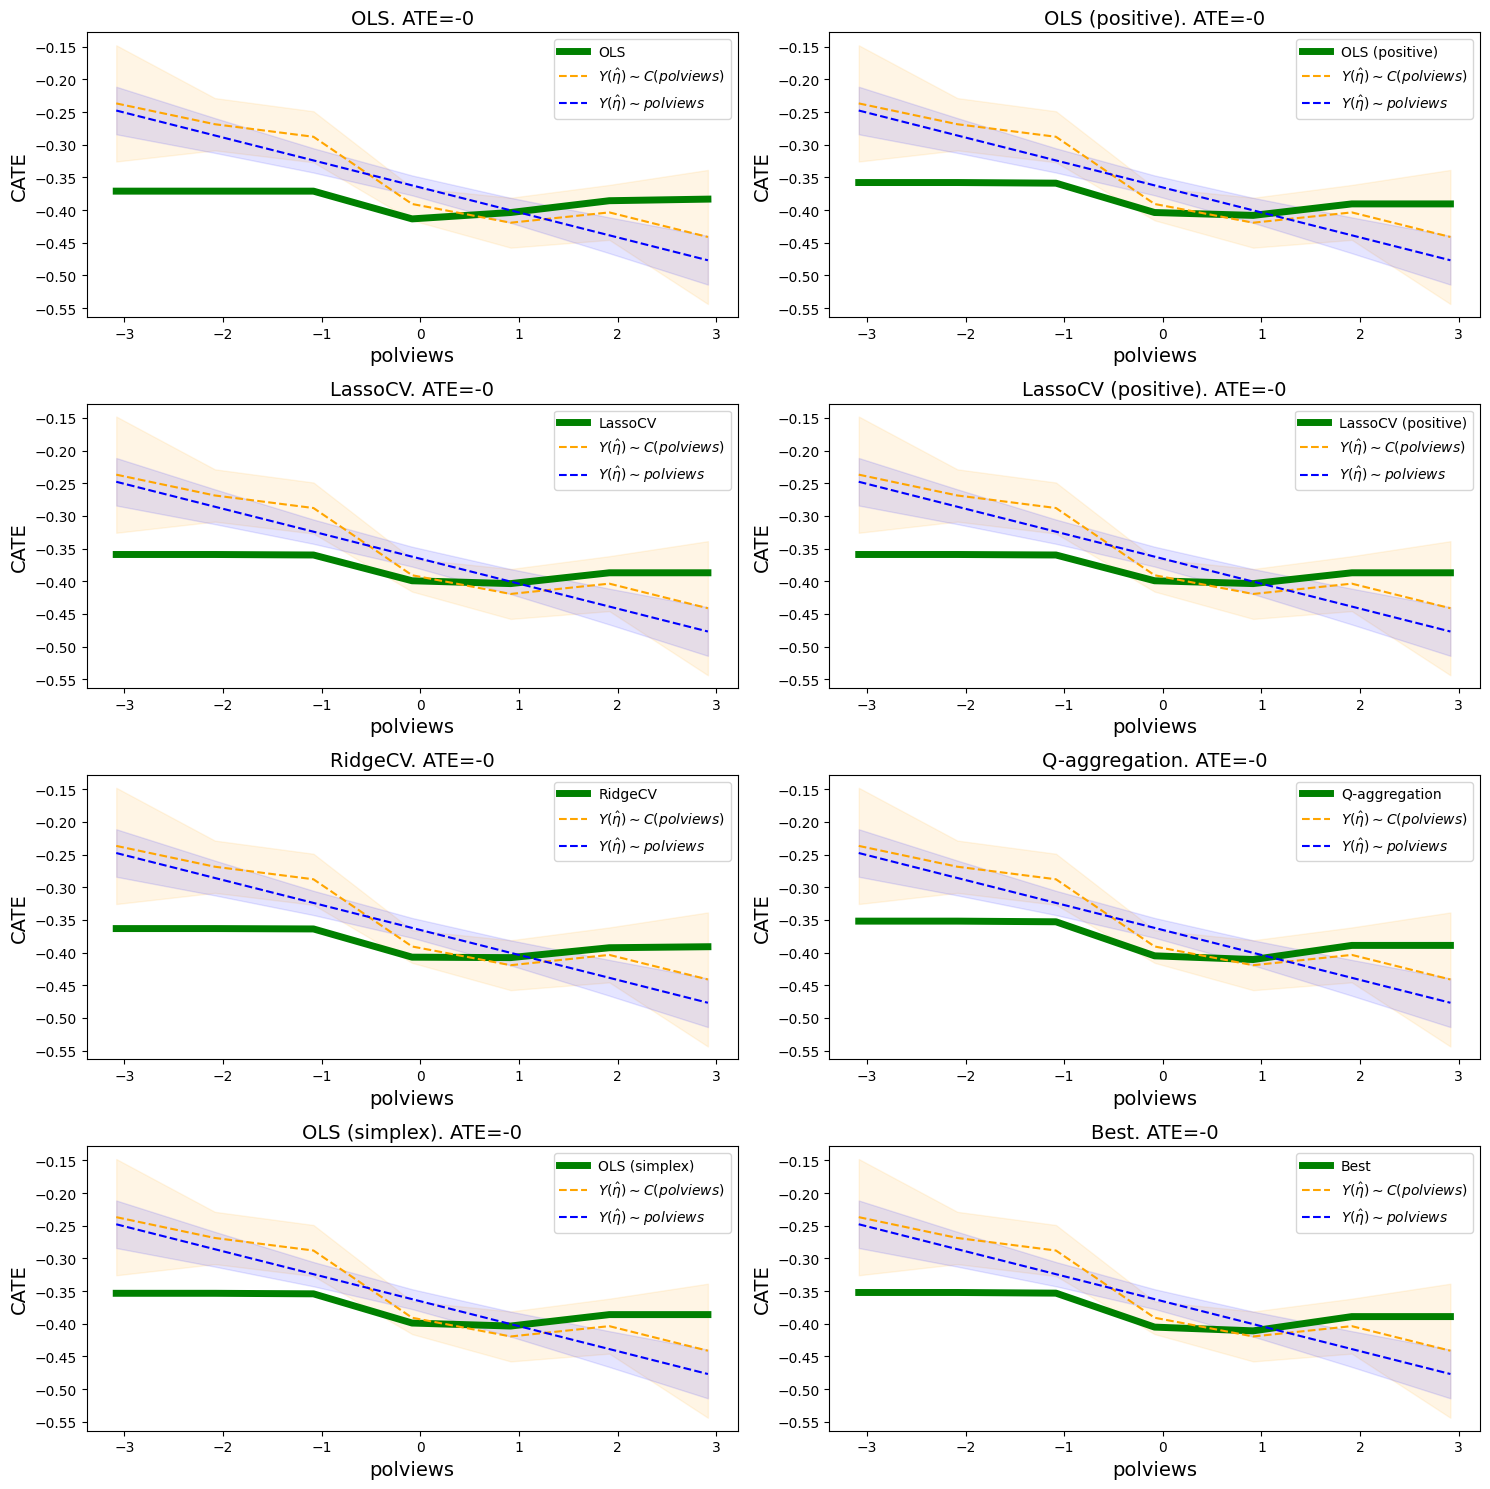

PermutationExplainer explainer: 101it [00:10,  1.21s/it]                         


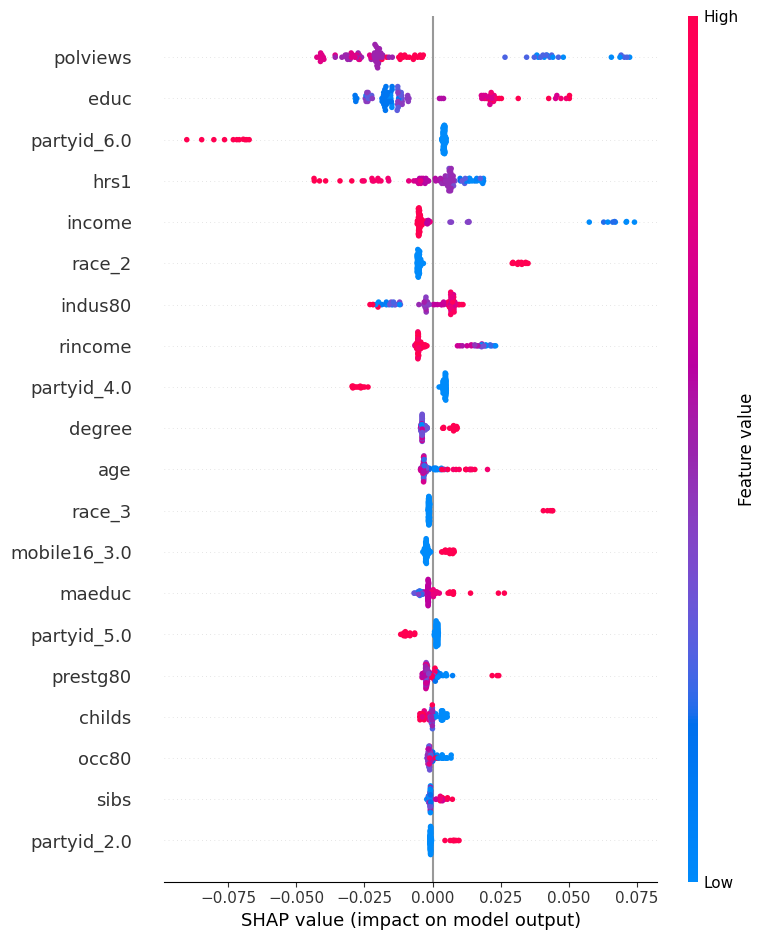

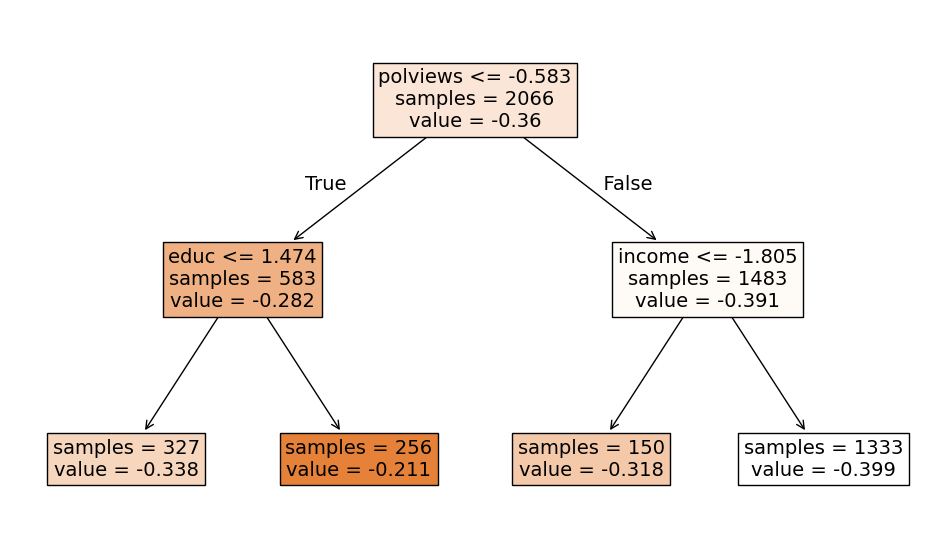

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     50.07
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           2.02e-12
Time:                        09:43:13   Log-Likelihood:                -2492.9
No. Observations:                2066   AIC:                             4990.
Df Residuals:                    2064   BIC:                             5001.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3642      0.018    -20.461      0.000      -0.399      -0.329
x1             1.4650      0.207      7.076      0.000       1.059       1.871
==============================================================================
Omnibus:                      124.701   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.418
Skew:                           0.469   Prob(JB):                     3.49e-23
Kurtosis:                       2.432   Cond. No.                         12.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [56]:
from sklearn.base import BaseEstimator


class Ensemble(BaseEstimator):

    def __init__(self, names, models, weights, intercept=0):
        self.names = names
        self.models = models
        self.weights = weights
        self.intercept = intercept

    def predict(self, X):
        wcate = np.sum(self.weights.reshape((-1, 1)) * np.array([m.predict(X) for m in self.models]), axis=0)
        return self.intercept + wcate


from sklearn.linear_model import RidgeCV, LinearRegression

F = np.array([m.predict(Zval) for m in models]).T
meansF = np.mean(F, axis=0)
F = F - meansF

stack_models = {}
stack_variants = [('OLS', LinearRegression(fit_intercept=False)),
                  ('OLS (positive)', LinearRegression(fit_intercept=False, positive=True)),
                  ('LassoCV', LassoCV(fit_intercept=False)),
                  ('LassoCV (positive)', LassoCV(fit_intercept=False, positive=True)),
                  ('RidgeCV', RidgeCV(fit_intercept=False))]

for stackname, stacker in stack_variants:
    stacker.fit(F, dr_val - np.mean(dr_preds))
    intercept = np.mean(dr_preds) - meansF @ stacker.coef_
    stack_models[stackname] = Ensemble(names, models, stacker.coef_, intercept)
    
    
def instance(nu, U, y):
    n = y.shape[0]
    ploss = np.mean((y.reshape(1, -1) - U)**2, axis=1)

    def loss(x):
        return np.mean((y - U.T @ x)**2)

    def qfunction(x):
        return (1 - nu) * loss(x) + nu * x @ ploss

    def grad_q(x):
        return - 2 * (1 - nu) * U @ (y - U.T @ x) / n + nu * ploss

    return loss, qfunction, grad_q, ploss


def opt(K, qfunction, grad_q):
    res = scipy.optimize.minimize(qfunction, np.ones(K) / K, jac=grad_q, bounds=[(0, 1)] * K,
                                  constraints=scipy.optimize.LinearConstraint(np.ones((1, K)), lb=1, ub=1),
                                  tol=1e-18)
    return res.x


def qagg(F, y, nu=.5):
    scale = max(np.max(np.abs(F)), np.max(np.abs(y)))
    loss, qfunction, grad_q, ploss = instance(nu, F.T / scale, y / scale)
    return opt(F.shape[1], qfunction, grad_q)


F = np.array([m.predict(Zval) for m in models]).T
weights = qagg(F, dr_val)
stack_models['Q-aggregation'] = Ensemble(names, models, weights, 0.0)

F = np.array([m.predict(Zval) for m in models]).T
weights = qagg(F, dr_val, nu=0.0)
stack_models['OLS (simplex)'] = Ensemble(names, models, weights, 0.0)

F = np.array([m.predict(Zval) for m in models]).T
weights = qagg(F, dr_val, nu=1.0)
stack_models['Best'] = Ensemble(names, models, weights, 0.0)

plt.plot(names, stack_models['Q-aggregation'].weights, label='Q-aggregation')
plt.plot(names, stack_models['Best'].weights, label='Best')
plt.plot(names, stack_models['OLS (simplex)'].weights, label='OLS (simplex)')
plt.legend()
plt.show()

print(f"Weights for Q-aggregation: {stack_models['Q-aggregation'].weights}")
print(f"Weights for Best: {stack_models['Best'].weights}")
print(f"Weights for OLS (simplex): {stack_models['OLS (simplex)'].weights}")

if plot:
    stack_ensemble = stack_models['Q-aggregation']
    grid = np.unique(np.percentile(X[xfeat], np.arange(0, 102, 2)))
    Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                       columns=X.columns)
    Xpd[xfeat] = grid
    plt.figure(figsize=(10, 5))
    plt.plot(Xpd[xfeat], stack_ensemble.predict(Xpd[hetero_feats]),
             linewidth=5, color='green',
             label='Q-aggregate')
    plt.plot(Xpd[xfeat], pred_df['mean'], '--', color='orange',
             label='$Y(\\hat{\\eta})\\sim ' + f'{blp_formula_short}$')
    plt.fill_between(Xpd[xfeat], pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], color='orange', alpha=.1)
    plt.plot(Xpd[xfeat], pred_df2['mean'], '--', color='blue',
             label='$Y(\\hat{\\eta})\\sim ' + f'{blp_formula2_short}$')
    plt.fill_between(Xpd[xfeat], pred_df2['mean_ci_lower'], pred_df2['mean_ci_upper'], color='blue', alpha=.1)
    if semi_synth:
        plt.plot(Xpd[xfeat], true_cate(Xpd), '--', label='True')
        plt.title(f'{score_name}={scorer(stack_ensemble.predict(Zval)):.5f}, '
                  f'True RMSE={rmse(true_cate(X), stack_ensemble.predict(Z)):.5f}')
    else:
        plt.title('Q-aggregate CATE Model, '
                  f'ATE={np.mean(stack_ensemble.predict(Zval)):.5f}')
    plt.xlabel(xfeat)
    plt.ylabel('CATE')
    plt.legend()
    plt.savefig(f'{data}-qagg.png', dpi=600)
    plt.show()
    

if plot:
    grid = np.unique(np.percentile(X[xfeat], np.arange(0, 102, 2)))
    Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                       columns=X.columns)
    Xpd[xfeat] = grid
    plt.figure(figsize=(15, 15))
    for it, (name, model) in enumerate(stack_models.items()):
        plt.subplot(4, len(stack_models) // 4, it + 1)
        preds = model.predict(Xpd[hetero_feats])
        plt.plot(Xpd[xfeat], preds, linewidth=5, color='green', label=name)
        plt.plot(Xpd[xfeat], pred_df['mean'], '--', color='orange',
                 label='$Y(\\hat{\\eta})\\sim ' + f'{blp_formula_short}$')
        plt.fill_between(Xpd[xfeat], pred_df['mean_ci_lower'], pred_df['mean_ci_upper'],
                         color='orange', alpha=.1)
        plt.plot(Xpd[xfeat], pred_df2['mean'], '--', color='blue',
                 label='$Y(\\hat{\\eta})\\sim ' + f'{blp_formula2_short}$')
        plt.fill_between(Xpd[xfeat], pred_df2['mean_ci_lower'], pred_df2['mean_ci_upper'],
                         color='blue', alpha=.1)
        if semi_synth:
            plt.plot(Xpd[xfeat], true_cate(Xpd), label='True')
            plt.title(f'True RMSE={rmse(true_cate(X), model.predict(Z)):.5f}')
        else:
            plt.title(f'{name}. ATE={np.mean(model.predict(Zval)):.0f}', fontsize=14)
        plt.legend()
        plt.xlabel(xfeat, fontsize=14)
        plt.ylabel('CATE', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{data}-stacked_ensembles.png', dpi=600)
    plt.show()
    
overall_best = stack_models['Q-aggregation']

import shap

subsample = np.random.choice(Z.shape[0], min(1000, Z.shape[0]), replace=False)
explainer = shap.Explainer(overall_best.predict, masker=Z.iloc[subsample])
subsample = np.random.choice(Z.shape[0], min(100, Z.shape[0]), replace=False)
shap_values = explainer(Z.iloc[subsample])

plt.figure()
shap.summary_plot(shap_values, Z.iloc[subsample], show=False)
plt.savefig(f'{data}-shap-values.png', dpi=600)
plt.show()

# Interpret with Distillation Trees

plt.figure(figsize=(12, 7))
tree = DecisionTreeRegressor(max_depth=2, min_samples_leaf=100,
                             min_impurity_decrease=.00001, random_state=random_seed)
tree.fit(Ztest, overall_best.predict(Ztest))
plot_tree(tree, filled=True, feature_names=list(Ztest.columns), fontsize=14, impurity=False)
plt.savefig(f'{data}-distill-tree-cate.png', dpi=600)
plt.show()

# Validation Tests on Test Data 

dr_test = calculate_dr_outcomes(reg_zero_on_train, reg_one_on_train, prop_on_train,
                                Xtest, Dtest, ytest)
cate_test = overall_best.predict(Ztest)
res = OLS(dr_test, np.stack((np.ones(len(dr_test)), cate_test - np.mean(cate_test)), axis=-1))
res = res.fit(cov_type='HC1').summary()
res

b.

The meta learners with positive weights for Q-aggregation are all except for the X-learner, although all weights apart from the t-learner are very small. The meta learners with positive weights for best are all except for X-learner and DR-learner, although again all weights apart from the t-learner are basically also zero. The meta learners with positive weights for OLS simplex are all of them, although the S-learner, X-learner and the DR-learner are again basically zero. 

The important features for Q-aggregation according to a shap value analysis can be seen above, with importance from top to bottom. The top five most important features are polviews, educ, partyid_6.0, hrs1, and income.  

If we distill Q-aggregation as a binary decision tree, the important features are polviews at the root, educ and income at the second level. The distillation tree uncovers four groups, with the following characteristics:  

Group 1: polviews <= -0.583, educ <= 1.474. This group contains 327 samples and has an ATE of -0.338. Based on the characteristics, this group could be described as individuals with a low amount of formal education and a more liberal political ideology.
Group 2: polviews <= -0.583, educ > 1.474. This group contains 256 samples and has an ATE of -0.211. Based on the characteristics, this group could be described as individuals with a high amount of formal education and a more liberal political ideology.
Group 3: polviews > -0.583, income <= 1.805. This group contains 150 samples and has an ATE of -0.318. Based on the characteristics, this group could be described as individuals with a low income and a more conservative political ideology.
Group 4: polviews > -0.583, income > 1.805. This group contains 1333 samples and has an ATE of -0.399. Based on the characteristics, this group could be described as individuals with a high income and a more conservative political ideology.

When running validation on a third sample (the test set), we see that the coefficient is 1.465. It is statistically significant, but the 95% CI does not contain 1, so I would not say that the result is "close" to 1, even though the numerical value is.

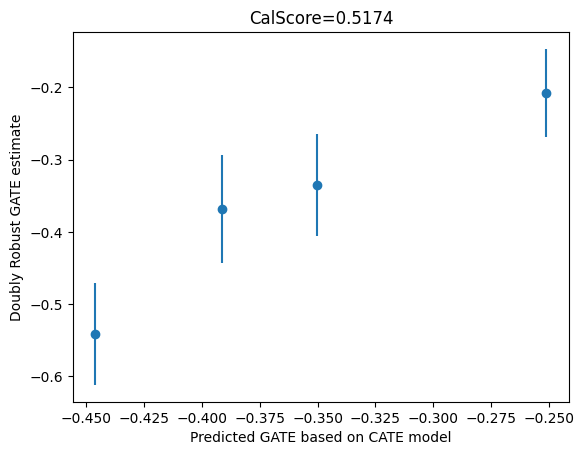

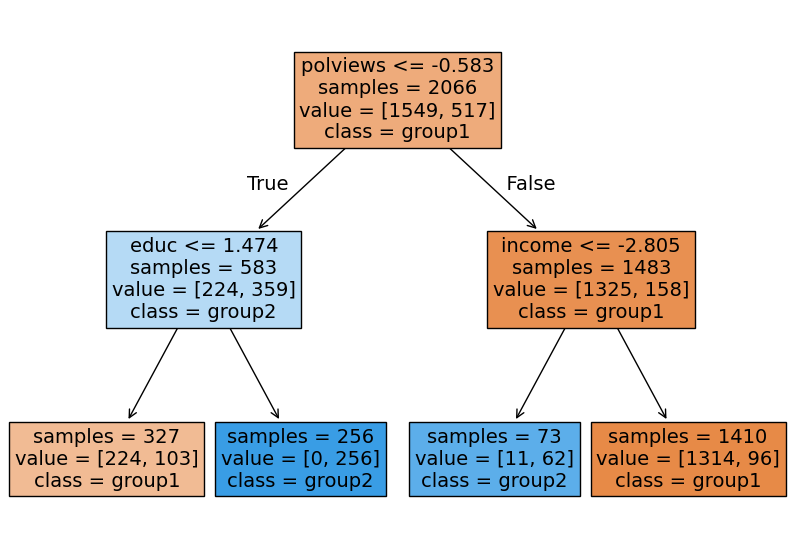

In [57]:
# Validation based on calibration

cate_val = overall_best.predict(Zval)
qs = np.percentile(cate_val, np.arange(0, 101, 25))

gate, gate_std, group_prob = np.zeros(len(qs) - 1), np.zeros(len(qs) - 1), np.zeros(len(qs) - 1)
predicted_gate = np.zeros(len(qs) - 1)
for it in range(len(qs) - 1):
    # samples in the [q[it], q[it+1]) quantile group of predicted CATEs
    inds = (qs[it] <= cate_test) & (cate_test <= qs[it + 1])
    gate[it] = np.mean(dr_test[inds])  # DR estimate of group average treatment effect (GATE)
    gate_std[it] = np.std(dr_test[inds]) / np.sqrt(np.sum(inds))  # standard error of GATE
    group_prob[it] = np.mean(inds)  # probability mass of group
    predicted_gate[it] = np.mean(cate_test[inds])  # GATE as calculated from CATE model

# weighted average calibration error of cate model
cal = np.sum(group_prob * np.abs(gate - predicted_gate))
# weighted average calibration error of a constant cate model
calbase = np.sum(group_prob * np.abs(gate - np.mean(dr_test)))
# calibration score
calscore = 1 - cal / calbase
plt.title(f'CalScore={calscore:.4f}')
plt.errorbar(predicted_gate, gate, yerr=1.96 * gate_std, fmt='o')
plt.xlabel('Predicted GATE based on CATE model')
plt.ylabel('Doubly Robust GATE estimate')
plt.savefig(f'{data}-calibration-score.png', dpi=600)
plt.show()

group1 = (qs[0] <= cate_test) & (cate_test < qs[3])
group2 = (qs[-2] <= cate_test) & (cate_test < qs[-1])
Ztest1 = Ztest[group1]
Ztest2 = Ztest[group2]
diff_stderr = np.std(Ztest1, axis=0) / np.sqrt(Ztest1.shape[0]) + np.std(Ztest2, axis=0) / np.sqrt(Ztest2.shape[0])
df = pd.DataFrame({'group1 means': np.mean(Ztest1, axis=0),
                   'group1 s.e.': np.std(Ztest1, axis=0) / np.sqrt(Ztest1.shape[0]),
                   'group2 means': np.mean(Ztest2, axis=0),
                   'group2 s.e.': np.std(Ztest2, axis=0) / np.sqrt(Ztest2.shape[0]),
                   'group1 means - group2 means': np.mean(Ztest1, axis=0) - np.mean(Ztest2, axis=0),
                   'diff s.e.': diff_stderr})

plt.figure(figsize=(10, 7))
tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=50, min_impurity_decrease=.01)
tree.fit(pd.concat((Ztest1, Ztest2)),
         np.concatenate((np.zeros(len(Ztest1)), np.ones(len(Ztest2)))))
plot_tree(tree, filled=True, feature_names=list(Ztest1.columns),
          class_names=['group1', 'group2'], fontsize=14, impurity=False)
plt.savefig(f'{data}-distill-groups-tree-cate.png', dpi=600)
plt.show()

Yes, we observe statistical separation between the lowest quartile and the other quartile. Based on the depth 2 decision tree, we have the following two groups:

Group 1: either polviews <= -0.583 and educ <= 1.474 or polviews > -0.583 and income > 2.805. This appears to be a mix of liberals with low education and conservatives with high income.
Group 2: either polviews <= -0.583 and educ > 1.474 or polviews > -0.583 and income <= 2.805. This appears to be a mix of relatively educated liberals and lower income conservatives.  

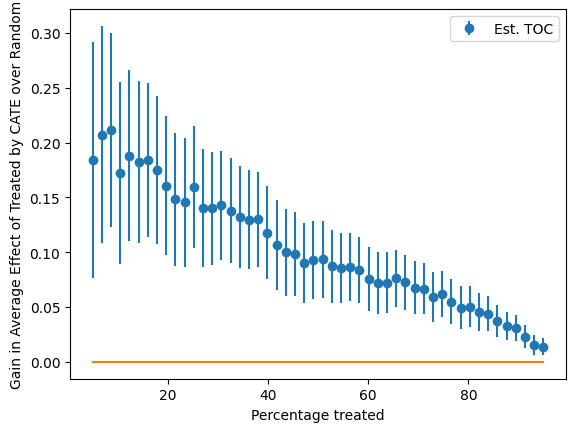

2.9528272258992656


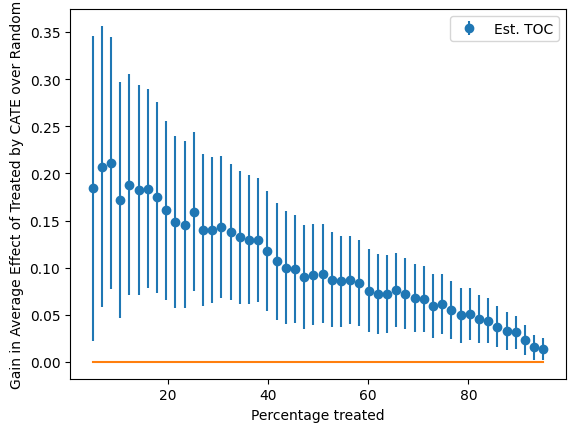

2.6913989423981


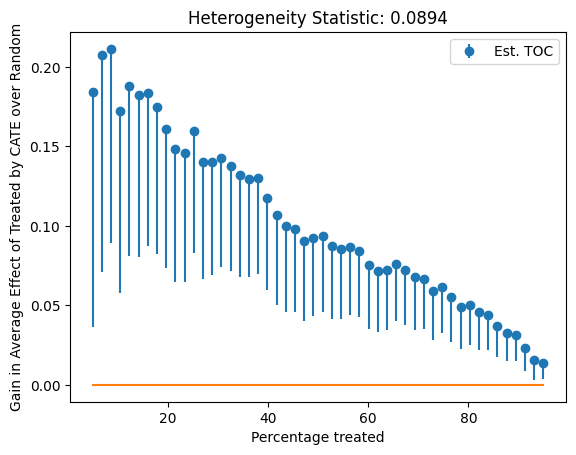

AUTOC: 0.0909, s.e.: 0.0132, One-Sided 95% CI=[0.0692, Infty]


In [59]:
# TOC and AUTOC curves


# Based on out-of-sample CATE thresholds
ugrid = np.linspace(5, 95, 50)
qs = np.percentile(overall_best.predict(Zval), ugrid)

toc, toc_std, group_prob = np.zeros(len(qs)), np.zeros(len(qs)), np.zeros(len(qs))
true_toc = np.zeros(len(qs))
toc_psi = np.zeros((len(qs), dr_test.shape[0]))  # influence function representation of the TOC at each quantile
n = len(dr_test)
ate = np.mean(dr_test)
uqs, ind, cnt = np.unique(qs, return_counts=True, return_index=True)
for it, u in enumerate(ugrid):
    # calculating tie breaking fraction
    intv = np.searchsorted(ugrid[ind], u, side='right') - 1
    q, i, c = uqs[intv], ind[intv], cnt[intv]
    nextu = (ugrid[i + c + 1] if i + c + 1 < len(ugrid) else 100)
    remnant = nextu - u
    frac = remnant / (nextu - ugrid[i])

    inds = (q < cate_test) + (cate_test == q) * frac  # group with larger CATE prediction than the q-th quantile
    group_prob = np.mean(inds)
    toc[it] = np.mean(dr_test * inds / group_prob) - ate  # tau(q) := E[Y(1) - Y(0) | tau(X) >= q[it]] - E[Y(1) - Y(0)]
    # influence function for the tau(q); it is a standard influence function of a "covariance"
    toc_psi[it, :] = (dr_test - ate) * (inds / group_prob - 1) - toc[it]
    toc_std[it] = np.sqrt(np.mean(toc_psi[it]**2) / n)  # standard error of tau(q)
    if semi_synth:
        true_toc[it] = np.mean((true_cate(Xtest) - np.mean(true_cate(Xtest))) * (inds / group_prob - 1))
        
        
plt.errorbar(100 - ugrid, toc, yerr=1.96 * toc_std, fmt='o', label='Est. TOC')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True TOC')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.legend()
plt.savefig(f'{data}-toc.png', dpi=600)
plt.show()

V = toc_psi @ toc_psi.T / toc_psi.shape[1]
sigmas = np.sqrt(np.diag(V))
V /= sigmas.reshape(-1, 1)
V /= sigmas.reshape(1, -1)

epsilon = np.random.multivariate_normal(np.zeros(V.shape[0]), V, size=(100000))
uniform_critical_value = np.percentile(np.max(np.abs(epsilon), axis=1), 95)
print(uniform_critical_value)

plt.errorbar(100 - ugrid, toc, yerr=uniform_critical_value * toc_std, fmt='o', label='Est. TOC')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True TOC')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.legend()
plt.savefig(f'{data}-toc-uniform-band.png', dpi=600)
plt.show()

uniform_one_side_critical_value = np.percentile(np.max(np.abs(epsilon), axis=1), 90)
print(uniform_one_side_critical_value)

plt.errorbar(100 - ugrid, toc,
             yerr=[uniform_one_side_critical_value * toc_std, np.zeros(len(toc))], fmt='o', label='Est. TOC')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True TOC')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.title(f'Heterogeneity Statistic: {np.max(toc - uniform_one_side_critical_value*toc_std):.4f}')
plt.legend()
plt.savefig(f'{data}-toc-one-sided-band.png', dpi=600)
plt.show()


autoc_psi = np.sum(toc_psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
autoc = np.sum(toc[:-1] * np.diff(ugrid) / 100)
autoc_stderr = np.sqrt(np.mean(autoc_psi**2) / n)
print(f'AUTOC: {autoc:.4f}, s.e.: {autoc_stderr:.4f}, '
      f'One-Sided 95% CI=[{autoc - scipy.stats.norm.ppf(.95) * autoc_stderr:.4f}, Infty]')

d.) Yes, these curves demonstrate statistically significant heterogeneity in the treatment effect, as there are points above the zero line. Looking at the plot, we can see that if we look at the top 20% percentile of the CATE prediction he difference between the group average treatment effect of that group vs the average treatment effect of the whole population is approximately 0.15. 

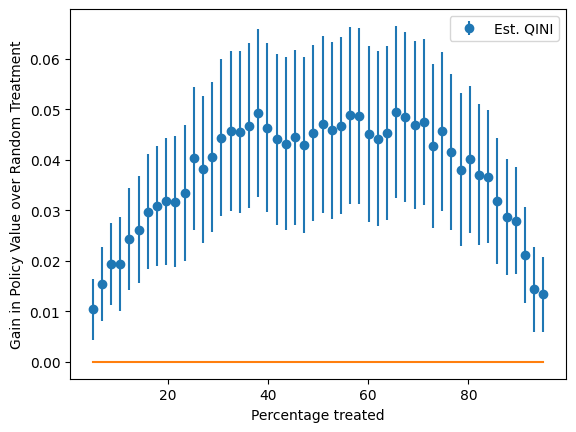

2.947998266920572


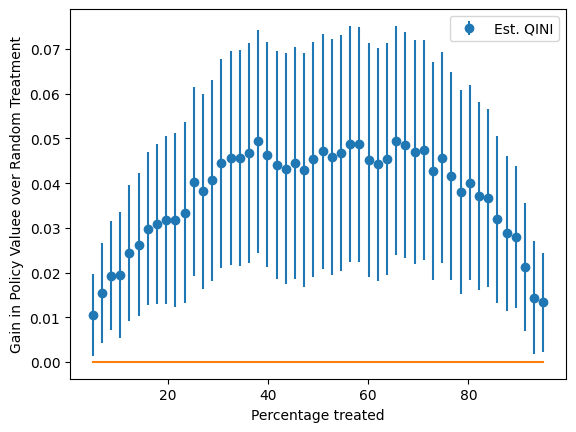

2.689224039593724


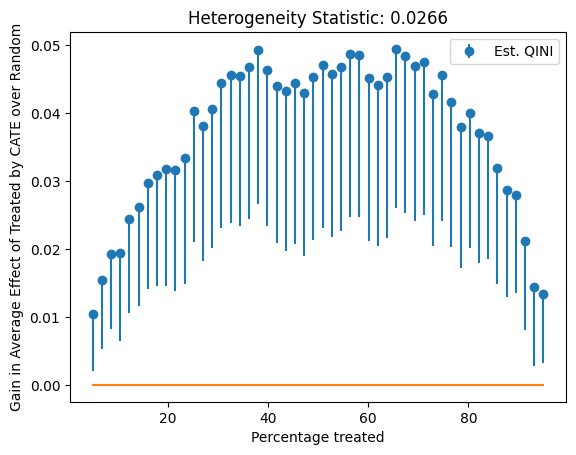

QINI: 0.0342, s.e.: 0.0049, One-Sided 95% CI=[0.0262, Infty]


In [60]:
# QINI curve 

# Based on out-of-sample CATE thresholds
ugrid = np.linspace(5, 95, 50)
qs = np.percentile(overall_best.predict(Zval), ugrid)

toc, toc_std, group_prob = np.zeros(len(qs)), np.zeros(len(qs)), np.zeros(len(qs))
true_toc = np.zeros(len(qs))
toc_psi = np.zeros((len(qs), dr_test.shape[0]))
n = len(dr_test)
ate = np.mean(dr_test)
uqs, ind, cnt = np.unique(qs, return_counts=True, return_index=True)
for it, u in enumerate(ugrid):
    # calculating tie breaking fraction
    intv = np.searchsorted(ugrid[ind], u, side='right') - 1
    q, i, c = uqs[intv], ind[intv], cnt[intv]
    nextu = (ugrid[i + c + 1] if i + c + 1 < len(ugrid) else 100)
    remnant = nextu - u
    frac = remnant / (nextu - ugrid[i])

    inds = (q < cate_test) + (cate_test == q) * frac  # group with larger CATE prediction than the q-th quantile
    group_prob = np.mean(inds)
    # tau(q) = q * E[Y(1) - Y(0) | tau(X) >= q[it]] - E[Y(1) - Y(0)]
    toc[it] = np.mean((dr_test - ate) * (inds - group_prob))
    toc_psi[it, :] = (dr_test - ate) * (inds - group_prob) - toc[it]  # influence function for the tau(q)
    toc_std[it] = np.sqrt(np.mean(toc_psi[it]**2) / n)  # standard error of tau(q)
    if semi_synth:
        true_toc[it] = np.mean((true_cate(Xtest) - np.mean(true_cate(Xtest))) * (inds - group_prob))
        
        
plt.errorbar(100 - ugrid, toc, yerr=1.96 * toc_std, fmt='o', label='Est. QINI')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True QINI')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Policy Value over Random Treatment")
plt.legend()
plt.savefig(f'{data}-qini.png', dpi=600)
plt.show()


V = toc_psi @ toc_psi.T / toc_psi.shape[1]
sigmas = np.sqrt(np.diag(V))
V /= sigmas.reshape(-1, 1)
V /= sigmas.reshape(1, -1)

epsilon = np.random.multivariate_normal(np.zeros(V.shape[0]), V, size=(100000))
uniform_critical_value = np.percentile(np.max(np.abs(epsilon), axis=1), 95)
print(uniform_critical_value)

plt.errorbar(100 - ugrid, toc, yerr=uniform_critical_value * toc_std, fmt='o', label='Est. QINI')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True QINI')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Policy Valuee over Random Treatment")
plt.legend()
plt.savefig(f'{data}-qini-band.png', dpi=600)
plt.show()

uniform_one_side_critical_value = np.percentile(np.max(np.abs(epsilon), axis=1), 90)
print(uniform_one_side_critical_value)

plt.errorbar(100 - ugrid, toc, yerr=[uniform_one_side_critical_value * toc_std, np.zeros(len(toc))],
             fmt='o', label='Est. QINI')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True QINI')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.title(f'Heterogeneity Statistic: {np.max(toc - uniform_one_side_critical_value*toc_std):.4f}')
plt.legend()
plt.savefig(f'{data}-qini-one-sided-band.png', dpi=600)
plt.show()

qini_psi = np.sum(toc_psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
qini = np.sum(toc[:-1] * np.diff(ugrid) / 100)
qini_stderr = np.sqrt(np.mean(qini_psi**2) / n)
print(f'QINI: {qini:.4f}, s.e.: {qini_stderr:.4f}, '
      f'One-Sided 95% CI=[{qini - scipy.stats.norm.ppf(.95) * qini_stderr:.4f}, Infty]')

As can be seen by the plots, the estimated increase in the policy value as compared to the policy that treats a random 40% of the population from treating the top 40% percentile of the CATE prediction is just over 0.04. 

### Assignment 3

env: PYTHONWARNINGS=ignore
Estimating ATET for year 2004. Please wait.
Estimating No Controls.
Estimating Basic.
Estimating Expansion.
Estimating Lasso (CV).
Estimating Ridge (CV).
Estimating Random Forest.
Estimating ATET for year 2005. Please wait.
Estimating No Controls.
Estimating Basic.
Estimating Expansion.
Estimating Lasso (CV).
Estimating Ridge (CV).
Estimating Random Forest.
Estimating ATET for year 2006. Please wait.
Estimating No Controls.
Estimating Basic.
Estimating Expansion.
Estimating Lasso (CV).
Estimating Ridge (CV).
Estimating Random Forest.
Estimating ATET for year 2007. Please wait.
Estimating No Controls.
Estimating Basic.
Estimating Expansion.
Estimating Lasso (CV).
Estimating Ridge (CV).
Estimating Random Forest.
                   2004                2005                2006            \
                 RMSE D   RMSE dy    RMSE D   RMSE dy    RMSE D   RMSE dy   
No Controls    0.198170  0.163240  0.200574  0.188136  0.211096  0.223408   
Basic          0.19002

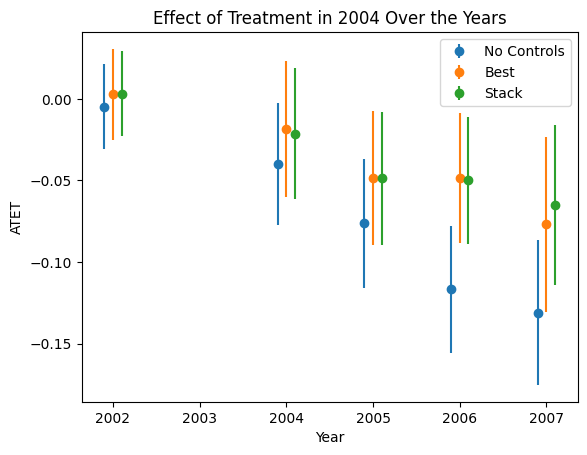

In [62]:
%env PYTHONWARNINGS=ignore
import numpy as np
import pandas as pd
import doubleml as dml
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.pipeline import make_pipeline
import warnings

warnings.filterwarnings("ignore")
np.random.seed(772023)

from sklearn.base import TransformerMixin, BaseEstimator
from formulaic import Formula


class FormulaTransformer(TransformerMixin, BaseEstimator):

    def __init__(self, formula):
        self.formula = formula

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = Formula(self.formula).get_model_matrix(X)
        return df.values.astype(np.float64)
    
data = pd.read_csv("https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/minwage_data.csv",
                   index_col=0)

data = data.loc[(data.G == 0) | (data.G > 2001)]
data.drop(columns=["countyreal", "state_name", "FIPS", "emp0A01_BS",
                   "quarter", "censusdiv", "pop", "annual_avg_pay",
                   "state_mw", "fed_mw", "ever_treated"], inplace=True)
years = [2001, 2002, 2003, 2004, 2005, 2006, 2007]
treat, cont = {}, {}
for year in years:
    treat[year] = data.loc[(data.G == 2004) & (data.year == year)].copy()
    cont[year] = data.loc[((data.G == 0) | (data.G > year)) & (data.year == year)].copy()
    
treat[2001].drop(columns=["year", "G", "region", "treated"], inplace=True)
cont[2001].drop(columns=["year", "G", "region", "treated"], inplace=True)

treatB = pd.merge(treat[2003], treat[2001], on="id", suffixes=["_pre", "_0"])
treatB.drop(columns=["treated", "lpop_pre", "lavg_pay_pre", "year", "G"], inplace=True)

contB = pd.merge(cont[2003], cont[2001], on="id", suffixes=["_pre", "_0"])
contB.drop(columns=["treated", "lpop_pre", "lavg_pay_pre", "year", "G"], inplace=True)


tdid, cdid = {}, {}
did_data = {}
# the first year will be used for pre-trend testing later on
for year in [2002, 2004, 2005, 2006, 2007]:
    treat[year].drop(columns=["lpop", "lavg_pay", "year", "G", "region"], inplace=True)
    cont[year].drop(columns=["lpop", "lavg_pay", "year", "G", "region"], inplace=True)

    tdid[year] = pd.merge(treat[year], treatB, on="id")
    tdid[year]["dy"] = tdid[year]["lemp"] - tdid[year]["lemp_pre"]
    tdid[year].drop(columns=["id", "lemp", "lemp_pre"], inplace=True)
    tdid[year].treated = 1  # forcing treatment to be 1, so that 2002 is "treated" when testing pre-trends

    cdid[year] = pd.merge(cont[year], contB, on="id")
    cdid[year]["dy"] = cdid[year]["lemp"] - cdid[year]["lemp_pre"]
    cdid[year].drop(columns=["id", "lemp", "lemp_pre"], inplace=True)

    # join control and treatment data and create one-hot-encoded region variables
    did_data[year] = pd.concat((tdid[year], cdid[year]))
    dummy_data = pd.get_dummies(did_data[year].region, drop_first=True, prefix="region")
    did_data[year] = pd.concat((did_data[year], dummy_data), axis=1).drop(columns=["region"])
    
def final_stage(D, y, Dhat, yhat, phat):
    # doubly robust quantity for every sample
    phihat = ((D - Dhat) / (phat * (1 - Dhat))) * (y - yhat)
    point = np.mean(phihat) / np.mean(D / phat)
    # influence function
    phihat = (phihat - point * (D / phat)) / np.mean(D / phat)
    var = np.mean(np.square(phihat))
    stderr = np.sqrt(var / D.shape[0])
    return point, stderr


def dr_att(X, D, y, modely, modeld, *, trimming=0.01, nfolds=5):
    '''
    DML for the ATT estimation (Doubly Robust Learning)
    with cross-fitting

    Input
    -----
    X: the controls, pandas DataFrame
    D: treatment indicator, numpy array
    y: the outcome (the delta before and after intervention in DiD), numpy array
    modely: the ML model for predicting y (the delta Y_1 - Y_0 in DiD)
    modeld: the ML model for predicting the treatment D
    trimming: threshold below which to trim propensities, float (default=0.01)
    nfolds: the number of folds in cross-fitting, int (default=5)

    Output
    ------
    point: the point estimate of the treatment on the treated
    stderr: the standard error of the treatment effect
    yhat: cross-fitted predictions of the outcome y under control, E[y|D=0, X]
    Dhat: cross-fitted predictions of the treatment D, E[D|X]
    rmsey: the RMSE of the model y ~ X | D==0
    rmseD: the RMSE of the model D ~ X
    phat: the estimated treatment probability in each fold
    '''
    cv = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=1234)
    # fit a model E[y | D=0, X]
    yhat = np.zeros(y.shape)
    for train, test in cv.split(X, D):
        modely.fit(X.iloc[train][D[train] == 0], y[train][D[train] == 0])
        yhat[test] = modely.predict(X.iloc[test])
    # fit a model P[D]
    phat = cross_val_predict(DummyRegressor(), X, D, cv=cv)
    # propensity scores E[D | X]
    Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba')[:, 1]
    # trimm propensity score
    Dhat = np.clip(Dhat, trimming, 1 - trimming)
    # estimation of parameter
    point, stderr = final_stage(D, y, Dhat, yhat, phat)
    # nuisance function rmse's
    rmsey = np.sqrt(np.mean((y - yhat)[D == 0]**2))
    rmseD = np.sqrt(np.mean((D - Dhat)**2))
    return point, stderr, yhat, Dhat, rmsey, rmseD, phat

def get_nuisance_learners(region_names):
    ''' Constructs the learners we will consider for nuisance estimation

    region_names: the available region names

    Returns: a dictionary of learners of the form {key: (ml_g, ml_m)}
    '''
    # a formula that will be used within a featurizer to create interactions
    # (region id) * (baseline outcome) + (region id) + (baseline outcomes)
    formula = '0 + ' + ' + '.join([f"{col} * (lemp_0 + lpop_0 + lavg_pay_0)" for col in region_names])

    # a generic polynomial featurizer
    def poly():
        return PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)

    learners = {
        # no X
        "No Controls": (DummyRegressor(strategy="mean"), DummyClassifier(strategy="prior")),
        # linear models of X
        "Basic": (LinearRegression(), LogisticRegression(random_state=123)),
        # linear models with region interactions
        "Expansion": (make_pipeline(FormulaTransformer(formula), LinearRegression()),
                      make_pipeline(FormulaTransformer(formula), LogisticRegression(random_state=123))),
        # full blown third degree interactions of X, with Lasso
        "Lasso (CV)": (make_pipeline(poly(), LassoCV(n_jobs=-1, random_state=123)),
                       make_pipeline(poly(), LogisticRegressionCV(penalty="l1", solver="liblinear",
                                                                  n_jobs=-1, random_state=123))),
        # full blown third degree interactions, with Ridge
        "Ridge (CV)": (make_pipeline(poly(), RidgeCV()),
                       make_pipeline(poly(), LogisticRegressionCV(n_jobs=-1, random_state=123))),
        # Random Forest regressors and classifiers
        "Random Forest": (RandomForestRegressor(n_estimators=100, min_samples_leaf=20, max_features=4,
                                                n_jobs=-1, random_state=123),
                          RandomForestClassifier(n_estimators=100, min_samples_leaf=20, max_features=4,
                                                 n_jobs=-1, random_state=123))
    }
    return learners


def MinWageDiD(years):
    # arrays for saving the results
    att, se_att, RMSE_d, RMSE_y = {}, {}, {}, {}

    for year in years:
        print(f"Estimating ATET for year {year}. Please wait.")
        att[year], se_att[year], RMSE_d[year], RMSE_y[year] = {}, {}, {}, {}

        # set up the data for the specific year
        X = did_data[year].drop(columns=["treated", "dy"])  # controls
        D = did_data[year].treated.values  # treatment
        dy = did_data[year].dy.values  # delta outcome betwee post and pre treatment
        region_names = [col for col in X.columns if col.startswith('region_')]

        # get dictionary of nuisance learners
        learners = get_nuisance_learners(region_names)

        # for storing the nuisance predictions
        pred_y, pred_d = {}, {}
        for method, (ml_g, ml_m) in learners.items():
            print(f"Estimating {method}.")
            point, stderr, dyhat, Dhat, rmsey, rmsed, phat = dr_att(X, D, dy, ml_g, ml_m, trimming=0.01, nfolds=5)
            pred_y[method], pred_d[method] = dyhat, Dhat
            att[year][method], se_att[year][method] = point, stderr
            RMSE_y[year][method], RMSE_d[year][method] = rmsey, rmsed

        # find best model for dy and d and use predictions
        besty = min(RMSE_y[year], key=RMSE_y[year].get)
        bestd = min(RMSE_d[year], key=RMSE_d[year].get)
        # phat this is the same for all methods and equal to the cross-fitted Pr[D=1]
        point, stderr = final_stage(D, dy, pred_d[bestd], pred_y[besty], phat)
        att[year]["Best"], se_att[year]["Best"] = point, stderr
        RMSE_y[year]["Best"] = RMSE_y[year][besty]
        RMSE_d[year]["Best"] = RMSE_d[year][bestd]

        # we can also find the best linear combination of models via stacking
        pred_y = pd.DataFrame(pred_y)
        pred_d = pd.DataFrame(pred_d)
        stacked_pred_y = LinearRegression().fit(pred_y, dy).predict(pred_y)
        stacked_pred_d = LinearRegression().fit(pred_d, D).predict(pred_d)
        # phat this is the same for all methods and equal to the cross-fitted Pr[D=1]
        point, stderr = final_stage(D, dy, stacked_pred_d, stacked_pred_y, phat)
        att[year]["Stack"], se_att[year]["Stack"] = point, stderr
        RMSE_y[year]["Stack"] = np.sqrt(np.mean((dy - stacked_pred_y)[D == 0]**2))
        RMSE_d[year]["Stack"] = np.sqrt(np.mean((D - stacked_pred_d)**2))

    return att, se_att, RMSE_y, RMSE_d


att, se_att, RMSE_y, RMSE_d = MinWageDiD([2004, 2005, 2006, 2007])


table1 = pd.concat({'RMSE dy': pd.DataFrame(RMSE_y),
                    'RMSE D': pd.DataFrame(RMSE_d)}, axis=1)
table1 = table1.swaplevel(0, 1, axis=1)
table1 = table1.sort_index(axis=1)
print(table1)


table2 = pd.concat({'att': pd.DataFrame(att),
                    'se': pd.DataFrame(se_att),
                    'RMSE dy': pd.DataFrame(RMSE_y),
                    'RMSE D': pd.DataFrame(RMSE_d)}, axis=1)
table2 = table2.swaplevel(0, 1, axis=1)
table2 = table2.sort_index(axis=1)
print(table2)

att, se_att, RMSE_y, RMSE_d = MinWageDiD([2002])

table2002 = pd.concat({'att': pd.DataFrame(att),
                       'se': pd.DataFrame(se_att),
                       'RMSE dy': pd.DataFrame(RMSE_y),
                       'RMSE D': pd.DataFrame(RMSE_d)}, axis=1)
table2002 = table2002.swaplevel(0, 1, axis=1)
table2002 = table2002.sort_index(axis=1)
print(table2002)

import matplotlib.pyplot as plt

table_all = pd.concat([table2002, table2], axis=1)
years = np.array([2002, 2004, 2005, 2006, 2007])
for it, method in enumerate(['No Controls', 'Best', 'Stack']):
    plt.errorbar(years + (it - 1) * .1,
                 np.array([table_all[year]['att'].loc[method] for year in years]),
                 yerr=1.96 * np.array([table_all[year]['se'].loc[method] for year in years]),
                 fmt='o', label=method)
plt.legend()
plt.xlabel('Year')
plt.ylabel('ATET')
plt.title('Effect of Treatment in 2004 Over the Years')
plt.show()

a.)

The intervention studied in the notebook is whether the county has a minimum wage above the federal minimum wage in the year 2004. This intervention is clearly defined as the county introducing a minimum wage that is greater than the federal minimum wage. Note that this is a binary treatment, and thus there is no distinction between minimum wages of different levels above the federal threshold. As such, both a county with a minimum wage of just 5ct above the national minimum wage and a county with a minimum wage of $5 above the national minimum wage will be defined as treated. We have panel data on USA counties minimum wages and some covariates from 2001 to 2007, where 2002 is the pre-trend period (and 2023 is used as the reference period). We also have pre-treatment variables: 2001 population, 2001 average pay and 2001 teen employment The studied outcome is the log of employment among teenagers at the county level.  


The average treatment effects on the treated discovered by the different diff-in-diff methods are summarized in the plot above. We can see that in the pre-treatment period (2002, which uses 2003 as the reference period), the effect estimate is statistically indifferent from zero, which is reassuring. We thus do not identify any placebo effects in the pre-trend period. In the post-treatment years we generally see negative treatment effects whose magnitudes increase over time. This makes sense intuitively, since it takes firms some times to restructure their employment in response to the increased minimum wage (hence the increase in effect magnitude over time) and basic economics dictates that ceteris paribus a higher wage should be accompanied by lower employment (hence the sign of the effect). Another important observation is that the effect magnitude is larger without controls, which indicates that we may overestimate the effect if we fail to control for covariates.  

b.) 

The no-anticipation assumption states:  For all units $i$ and time period $t < G_i$ (pre-treatment time periods),
$Y_{it} = Y_{it}(0)$ (Callaway 2022). This essentially means that the treatment effect is not anticipated by the units before the treatment is implemented. This is a crucial assumption in the diff-in-diff framework, as it ensures that the treatment effect is not confounded by anticipation effects. If the no-anticipation assumption is violated, then the diff-in-diff estimator will be biased. In our example, it is far from clear that this assumption holds. Decisions like raising the minimum wage often take time to implement and are often discussed in the public sphere before they are implemented. This means that firms and workers may anticipate the treatment and adjust their behavior before the treatment is implemented. This would violate the no-anticipation assumption and bias the diff-in-diff estimator.

The unconditional parallel trend assumption states that $E[Y_0^T|T] - E[Y_0^C|C]$ is constant over time, that is the difference in average outcomes between the treatment and control groups before treatment should be the same as the difference after treatment, had there been no treatment. In simpler terms, the outcome variable would have evolved similarly for both groups in the absence of treatment. This is a strong assumption because it implicitly assumes that no other factors influence the outcome differently across groups (in our case counties). It is again absolutely unclear whether or not this assumption holds in our setting. For example, it may be the case that counties with generally good economic outlook are more likely to raise their minimum wage, and these counties may also have a different trend in teenage employment than counties with a worse economic outlook. This would violate the unconditional parallel trend assumption and bias the diff-in-diff estimator.

The conditional parallel trend assumption states that $E[Y_0^T|T, X] - E[Y_0^C|C, X]$ is constant over time, that is the difference in average outcomes between the treatment and control groups before treatment should be the same as the difference after treatment, had there been no treatment, conditional on covariates. This is a weaker assumption than the unconditional parallel trend assumption, as it allows for different trends in the outcome variable across groups as long as these trends are the same conditional on covariates. In our setting, it is again unclear whether this assumption holds, since we use a limited set of controls. There may be impactful covariates that we do not control for, which would violate the conditional parallel trend assumption and bias the diff-in-diff estimator. For example, we do not measure the party affiliation of the county government, which may be an important covariate in determining the minimum wage policy of the county, as well as the employment of teenagers. Ommitting this covariate would then violate the conditional parallel trend assumption.

Estimating ATET for year 2005. Please wait.
Estimating No Controls.
Estimating Basic.
Estimating Expansion.
Estimating Lasso (CV).
Estimating Ridge (CV).
Estimating Random Forest.
Estimating ATET for year 2006. Please wait.
Estimating No Controls.
Estimating Basic.
Estimating Expansion.
Estimating Lasso (CV).
Estimating Ridge (CV).
Estimating Random Forest.
Estimating ATET for year 2007. Please wait.
Estimating No Controls.
Estimating Basic.
Estimating Expansion.
Estimating Lasso (CV).
Estimating Ridge (CV).
Estimating Random Forest.
                   2005                2006                2007          
                 RMSE D   RMSE dy    RMSE D   RMSE dy    RMSE D   RMSE dy
No Controls    0.158995  0.148501  0.167654  0.194260  0.200411  0.210474
Basic          0.126973  0.147321  0.127728  0.190453  0.065076  0.202303
Expansion      0.123224  0.148264  0.125008  0.190511  0.010014  0.202867
Lasso (CV)     0.182826  0.147446  0.194277  0.190294  0.021641  0.202663
Ridge (CV)     0

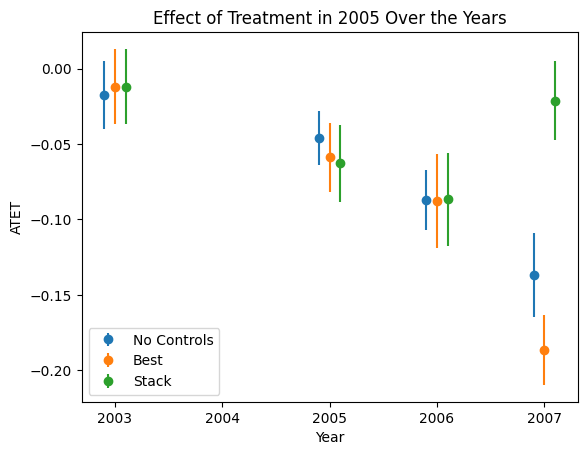

In [65]:
# c.) we now change the notebook to instead look at 2004 as the pre-treatment year and 2005 as the post-treatment year, using 2003 as the placebo period to identify the pre-treatment trends.

import numpy as np
import pandas as pd
import doubleml as dml
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.pipeline import make_pipeline
import warnings

warnings.filterwarnings("ignore")
np.random.seed(772023)

from sklearn.base import TransformerMixin, BaseEstimator
from formulaic import Formula


class FormulaTransformer(TransformerMixin, BaseEstimator):

    def __init__(self, formula):
        self.formula = formula

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = Formula(self.formula).get_model_matrix(X)
        return df.values.astype(np.float64)
    

data = pd.read_csv("https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/minwage_data.csv",
                   index_col=0)

# --------------------------------------------------------------------
# ADJUSTMENT 1: Restrict G > 2002 (instead of > 2001) so that G=2005 is valid.
# --------------------------------------------------------------------
data = data.loc[(data.G == 0) | (data.G > 2002)]

data.drop(columns=["countyreal", "state_name", "FIPS", "emp0A01_BS",
                   "quarter", "censusdiv", "pop", "annual_avg_pay",
                   "state_mw", "fed_mw", "ever_treated"], inplace=True)

# --------------------------------------------------------------------
# ADJUSTMENT 2: We shift our 'years' array by 1 so that it includes 2002..2007
#               (instead of 2001..2007).
# --------------------------------------------------------------------
years = [2002, 2003, 2004, 2005, 2006, 2007]
treat, cont = {}, {}
for year in years:
    # ----------------------------------------------------------------
    # ADJUSTMENT 3: Use (data.G == 2005) as the treated group.
    # ----------------------------------------------------------------
    treat[year] = data.loc[(data.G == 2005) & (data.year == year)].copy()
    cont[year] = data.loc[((data.G == 0) | (data.G > year)) & (data.year == year)].copy()
    
# --------------------------------------------------------------------
# ADJUSTMENT 4: Now 2002 is analogous to the old 2001 baseline 
# --------------------------------------------------------------------
treat[2002].drop(columns=["year", "G", "region", "treated"], inplace=True)
cont[2002].drop(columns=["year", "G", "region", "treated"], inplace=True)

# --------------------------------------------------------------------
# ADJUSTMENT 5: Create the baseline merges using 2004 as the "pre" 
#               and 2002 as the "_0" suffix.
# --------------------------------------------------------------------
treatB = pd.merge(treat[2004], treat[2002], on="id", suffixes=["_pre", "_0"])
treatB.drop(columns=["treated", "lpop_pre", "lavg_pay_pre", "year", "G"], inplace=True)

contB = pd.merge(cont[2004], cont[2002], on="id", suffixes=["_pre", "_0"])
contB.drop(columns=["treated", "lpop_pre", "lavg_pay_pre", "year", "G"], inplace=True)

tdid, cdid = {}, {}
did_data = {}

# --------------------------------------------------------------------
# ADJUSTMENT 6: We replace [2002, 2004, 2005, 2006, 2007] with
#               [2003, 2005, 2006, 2007]. Now 2003 is the “pre-trend check,” 
#               and 2005, 2006, 2007 are post-treatment.
# --------------------------------------------------------------------
for year in [2003, 2005, 2006, 2007]:
    treat[year].drop(columns=["lpop", "lavg_pay", "year", "G", "region"], inplace=True)
    cont[year].drop(columns=["lpop", "lavg_pay", "year", "G", "region"], inplace=True)

    tdid[year] = pd.merge(treat[year], treatB, on="id")
    tdid[year]["dy"] = tdid[year]["lemp"] - tdid[year]["lemp_pre"]
    tdid[year].drop(columns=["id", "lemp", "lemp_pre"], inplace=True)
    tdid[year].treated = 1  # same logic for the "treated" group

    cdid[year] = pd.merge(cont[year], contB, on="id")
    cdid[year]["dy"] = cdid[year]["lemp"] - cdid[year]["lemp_pre"]
    cdid[year].drop(columns=["id", "lemp", "lemp_pre"], inplace=True)

    did_data[year] = pd.concat((tdid[year], cdid[year]))
    dummy_data = pd.get_dummies(did_data[year].region, drop_first=True, prefix="region")
    did_data[year] = pd.concat((did_data[year], dummy_data), axis=1).drop(columns=["region"])


# -- Everything below is exactly as in the original code ----------------------------------

def final_stage(D, y, Dhat, yhat, phat):
    # doubly robust quantity for every sample
    phihat = ((D - Dhat) / (phat * (1 - Dhat))) * (y - yhat)
    point = np.mean(phihat) / np.mean(D / phat)
    # influence function
    phihat = (phihat - point * (D / phat)) / np.mean(D / phat)
    var = np.mean(np.square(phihat))
    stderr = np.sqrt(var / D.shape[0])
    return point, stderr


def dr_att(X, D, y, modely, modeld, *, trimming=0.01, nfolds=5):
    '''
    DML for the ATT estimation (Doubly Robust Learning)
    with cross-fitting
    '''
    cv = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=1234)
    # fit a model E[y | D=0, X]
    yhat = np.zeros(y.shape)
    for train, test in cv.split(X, D):
        modely.fit(X.iloc[train][D[train] == 0], y[train][D[train] == 0])
        yhat[test] = modely.predict(X.iloc[test])
    # fit a model P[D]
    phat = cross_val_predict(DummyRegressor(), X, D, cv=cv)
    Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba')[:, 1]
    Dhat = np.clip(Dhat, trimming, 1 - trimming)
    # estimation of parameter
    point, stderr = final_stage(D, y, Dhat, yhat, phat)
    rmsey = np.sqrt(np.mean((y - yhat)[D == 0]**2))
    rmseD = np.sqrt(np.mean((D - Dhat)**2))
    return point, stderr, yhat, Dhat, rmsey, rmseD, phat


def get_nuisance_learners(region_names):
    # same as original
    formula = '0 + ' + ' + '.join([f"{col} * (lemp_0 + lpop_0 + lavg_pay_0)" for col in region_names])

    def poly():
        return PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)

    learners = {
        "No Controls": (DummyRegressor(strategy="mean"), DummyClassifier(strategy="prior")),
        "Basic": (LinearRegression(), LogisticRegression(random_state=123)),
        "Expansion": (
            make_pipeline(FormulaTransformer(formula), LinearRegression()),
            make_pipeline(FormulaTransformer(formula), LogisticRegression(random_state=123))
        ),
        "Lasso (CV)": (
            make_pipeline(poly(), LassoCV(n_jobs=-1, random_state=123)),
            make_pipeline(poly(), LogisticRegressionCV(penalty="l1", solver="liblinear", n_jobs=-1, random_state=123))
        ),
        "Ridge (CV)": (
            make_pipeline(poly(), RidgeCV()),
            make_pipeline(poly(), LogisticRegressionCV(n_jobs=-1, random_state=123))
        ),
        "Random Forest": (
            RandomForestRegressor(n_estimators=100, min_samples_leaf=20, max_features=4, n_jobs=-1, random_state=123),
            RandomForestClassifier(n_estimators=100, min_samples_leaf=20, max_features=4, n_jobs=-1, random_state=123)
        )
    }
    return learners


def MinWageDiD(years):
    att, se_att, RMSE_d, RMSE_y = {}, {}, {}, {}

    for year in years:
        print(f"Estimating ATET for year {year}. Please wait.")
        att[year], se_att[year], RMSE_d[year], RMSE_y[year] = {}, {}, {}, {}

        X = did_data[year].drop(columns=["treated", "dy"])
        D = did_data[year].treated.values
        dy = did_data[year].dy.values
        region_names = [col for col in X.columns if col.startswith('region_')]

        learners = get_nuisance_learners(region_names)

        pred_y, pred_d = {}, {}
        for method, (ml_g, ml_m) in learners.items():
            print(f"Estimating {method}.")
            point, stderr, dyhat, Dhat, rmsey, rmsed, phat = dr_att(X, D, dy, ml_g, ml_m, trimming=0.01, nfolds=5)
            pred_y[method], pred_d[method] = dyhat, Dhat
            att[year][method], se_att[year][method] = point, stderr
            RMSE_y[year][method], RMSE_d[year][method] = rmsey, rmsed

        besty = min(RMSE_y[year], key=RMSE_y[year].get)
        bestd = min(RMSE_d[year], key=RMSE_d[year].get)
        point, stderr = final_stage(D, dy, pred_d[bestd], pred_y[besty], phat)
        att[year]["Best"], se_att[year]["Best"] = point, stderr
        RMSE_y[year]["Best"] = RMSE_y[year][besty]
        RMSE_d[year]["Best"] = RMSE_d[year][bestd]

        pred_y = pd.DataFrame(pred_y)
        pred_d = pd.DataFrame(pred_d)
        stacked_pred_y = LinearRegression().fit(pred_y, dy).predict(pred_y)
        stacked_pred_d = LinearRegression().fit(pred_d, D).predict(pred_d)
        point, stderr = final_stage(D, dy, stacked_pred_d, stacked_pred_y, phat)
        att[year]["Stack"], se_att[year]["Stack"] = point, stderr
        RMSE_y[year]["Stack"] = np.sqrt(np.mean((dy - stacked_pred_y)[D == 0]**2))
        RMSE_d[year]["Stack"] = np.sqrt(np.mean((D - stacked_pred_d)**2))

    return att, se_att, RMSE_y, RMSE_d


# ----------------------------------------------------------------
# The rest is exactly as your original script calls it:
# ----------------------------------------------------------------

att, se_att, RMSE_y, RMSE_d = MinWageDiD([2005, 2006, 2007])

table1 = pd.concat({'RMSE dy': pd.DataFrame(RMSE_y),
                    'RMSE D': pd.DataFrame(RMSE_d)}, axis=1)
table1 = table1.swaplevel(0, 1, axis=1)
table1 = table1.sort_index(axis=1)
print(table1)

table2 = pd.concat({'att': pd.DataFrame(att),
                    'se': pd.DataFrame(se_att),
                    'RMSE dy': pd.DataFrame(RMSE_y),
                    'RMSE D': pd.DataFrame(RMSE_d)}, axis=1)
table2 = table2.swaplevel(0, 1, axis=1)
table2 = table2.sort_index(axis=1)
print(table2)

att, se_att, RMSE_y, RMSE_d = MinWageDiD([2003])

table2003 = pd.concat({'att': pd.DataFrame(att),
                       'se': pd.DataFrame(se_att),
                       'RMSE dy': pd.DataFrame(RMSE_y),
                       'RMSE D': pd.DataFrame(RMSE_d)}, axis=1)
table2003 = table2003.swaplevel(0, 1, axis=1)
table2003 = table2003.sort_index(axis=1)
print(table2003)

import matplotlib.pyplot as plt

table_all = pd.concat([table2002, table2], axis=1)
years_plot = np.array([2003, 2005, 2006, 2007])
for it, method in enumerate(['No Controls', 'Best', 'Stack']):
    plt.errorbar(years_plot + (it - 1) * 0.1,
                 np.array([table_all[year]['att'].loc[method] for year in years_plot]),
                 yerr=1.96 * np.array([table_all[year]['se'].loc[method] for year in years_plot]),
                 fmt='o', label=method)
plt.legend()
plt.xlabel('Year')
plt.ylabel('ATET')
plt.title('Effect of Treatment in 2005 Over the Years')
plt.show()

Once again, we find no pre-trends, with all 2003 estimates not statistically different from 0. The overall picture of the treatment effects is similar to what we observed earlier, with two major differences: 

First, the magnitudes of the effects are increased, now reaching as low as -0.1 in 2006 (previously closer to -0.05) and as low as -0.2 by the "Best" methods in 2007 (previously closer to -0.1). 

Secondly, we now see a much larger discrepancy between the estimates of the different methods in 2007 and more similar estimates between estimates in 2006 and 2005. It is unclear where exactly this discrepancy comes from.